# ML Systems Final Project - Traffic Classification

## Table of Contents

### Setup
1. [Environment Setup](#Environment-Setup)
2. [Loading Data](#Loading-Data)

### Regular Dataset Methods
3. [Random Forest with Regular Dataset](#Random-Forest-with-Regular-Dataset)
   - [Easy Label (7 classes)](#Easy-Label-(7-classes))
   - [Medium Label (18 classes)](#Medium-Label-(18-classes))
   - [Hard Label (31 classes)](#Hard-Label-(31-classes))

4. [SVM with Regular Dataset](#SVM-with-Regular-Dataset)
   - [Easy Label (7 classes)](#Easy-Label-(7-classes))
   - [Medium Label (18 classes)](#Medium-Label-(18-classes))
   - [Hard Label (31 classes)](#Hard-Label-(31-classes))

5. [MLP with Regular Dataset](#MLP-with-Regular-Dataset)
   - [Easy Label (7 classes)](#Easy-Label-(7-classes))
   - [Medium Label (18 classes)](#Medium-Label-(18-classes))
   - [Hard Label (31 classes)](#Hard-Label-(31-classes))

### nPrint Dataset Methods
6. [Loading nPrint Data](#Loading-nPrint-Data)

7. [Random Forest with nPrint](#Random-Forest-with-nPrint)
   - [Easy Label (7 classes)](#Easy-Label-(7-classes))
   - [Medium Label (18 classes)](#Medium-Label-(18-classes))
   - [Hard Label (31 classes)](#Hard-Label-(31-classes))

8. [SVM with nPrint](#SVM-with-nPrint)
   - [Easy Label (7 classes)](#Easy-Label-(7-classes))
   - [Medium Label (18 classes)](#Medium-Label-(18-classes))
   - [Hard Label (31 classes)](#Hard-Label-(31-classes))

9. [MLP with nPrint](#MLP-with-nPrint)
   - [Easy Label (7 classes)](#Easy-Label-(7-classes))
   - [Medium Label (18 classes)](#Medium-Label-(18-classes))
   - [Hard Label (31 classes)](#Hard-Label-(31-classes))


## Environment Setup


In [1]:
# Install all required dependencies for pcapML → flows → features → ML
!pip install --upgrade pip

# Core pcapML tooling
!pip install pcapml-fe

# Data handling + ML
!pip install pandas scikit-learn numpy

# (Optional) AutoML — only if you want to compare to the leaderboard
!pip install autogluon

# Utility: progress bars (optional but recommended)
!pip install tqdm

!pip install seaborn


  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1
  Using cached pcapml_fe-0.0.3-cp313-cp313-macosx_14_0_arm64.whl
  Using cached scapy-2.6.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached dpkt-1.9.8-py3-none-any.whl.metadata (1.7 kB)
Using cached dpkt-1.9.8-py3-none-any.whl (194 kB)
Using cached scapy-2.6.1-py3-none-any.whl (2.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pcapml-fe]/3 [scapy]
  Using cached pandas-2.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached numpy-2.3.5-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.16.3-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached joblib-

In [2]:
#!/usr/bin/env python3
"""
End-to-end script for pcapML Application Identification (non-vpn2016).

Phase 1: Build a rich flow-level feature set from the pcapML dataset.

Assumes:
    - You are running in the same project directory that contains ./data/traffic.pcapng.gz
    - You have installed: pcapml-fe, pandas, scikit-learn, numpy

Input:
    ./data/traffic.pcapng.gz

Outputs:
    ./application_id_dataset.csv   - features + labels
    Prints Balanced Accuracy for a simple RandomForest on easy_label
"""

import os
import gzip
import tempfile
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder

import pcapml_fe   # pip install pcapml-fe


# ---------------------------------------------------------------------
# 1. Paths and decompression
# ---------------------------------------------------------------------

# For notebooks / scripts: use current working directory
BASE_DIR = Path(os.getcwd())
INPUT_GZ = BASE_DIR / "data" / "traffic.pcapng.gz"

assert INPUT_GZ.exists(), f"Input file not found: {INPUT_GZ}"

# Decompress to a temporary .pcapng file (pcapml_fe wants plain pcapng)
tmp_dir = tempfile.mkdtemp(prefix="pcapml_")
PCAP_PATH = Path(tmp_dir) / "traffic.pcapng"

with gzip.open(INPUT_GZ, "rb") as f_in, open(PCAP_PATH, "wb") as f_out:
    f_out.write(f_in.read())

print(f"Decompressed input to: {PCAP_PATH}")
print("Iterating over pcapML samples and extracting features + labels...")


# ---------------------------------------------------------------------
# 2. Feature extraction from each pcapML sample
# ---------------------------------------------------------------------

def _safe_moments(x: np.ndarray):
    """Return (mean, std, skew, kurt, cv) with safe handling for small arrays."""
    if x.size == 0:
        return 0.0, 0.0, 0.0, 0.0, 0.0
    mean = float(x.mean())
    std = float(x.std(ddof=0))
    if std > 0:
        z = (x - mean) / std
        skew = float((z ** 3).mean())
        kurt = float((z ** 4).mean())
    else:
        skew = 0.0
        kurt = 0.0
    cv = float(std / mean) if mean != 0 else 0.0
    return mean, std, skew, kurt, cv


def extract_features_from_sample(tsample):
    """
    Given a pcapML traffic_sample, compute rich per-sample flow features.
    Uses only packet sizes and timestamps, but tries to capture:
      - size distribution
      - timing / IAT distribution
      - burstiness / temporal shape
    Assumes:
        tsample.packets: iterable of packet-like objects with:
            - .raw_bytes (bytes)
            - .ts (timestamp float)
    """
    sizes = []
    times = []

    for pkt in tsample.packets:
        # Defensive: some implementations might not have these attributes
        try:
            sizes.append(len(pkt.raw_bytes))
            times.append(pkt.ts)
        except AttributeError:
            continue

    if not sizes:
        # zero-flow fallback: return zeros for all features
        return {k: 0.0 for k in [
            # basic
            "num_pkts", "total_bytes", "duration",
            # size stats
            "size_mean", "size_std", "size_skew", "size_kurt", "size_cv",
            "size_min", "size_max", "size_median",
            "size_q10", "size_q25", "size_q75", "size_q90",
            "size_range", "size_iqr", "size_max_over_mean",
            # IAT stats
            "iat_mean", "iat_std", "iat_skew", "iat_kurt", "iat_cv",
            "iat_min", "iat_max", "iat_median",
            "iat_q10", "iat_q25", "iat_q75", "iat_q90",
            "iat_range", "iat_iqr", "iat_max_over_mean",
            # rates
            "pkts_per_sec", "bytes_per_sec",
            # coarse size histogram (proportions)
            "prop_size_0_100", "prop_size_100_300",
            "prop_size_300_600", "prop_size_600_1000",
            "prop_size_gt_1000",
            # temporal / burstiness
            "prop_pkts_first_20", "prop_pkts_first_50", "prop_pkts_last_20",
            "prop_bytes_first_20", "prop_bytes_first_50", "prop_bytes_last_20",
            "time_fano_factor", "bytes_fano_factor",
        ]}

    sizes = np.asarray(sizes, dtype=float)
    times = np.asarray(times, dtype=float)

    num_pkts = sizes.size
    total_bytes = float(sizes.sum())

    # ------------------------------------------------------------
    # Basic size stats (shape of the payload distribution)
    # ------------------------------------------------------------
    size_mean, size_std, size_skew, size_kurt, size_cv = _safe_moments(sizes)
    size_min = float(sizes.min())
    size_max = float(sizes.max())
    size_median = float(np.median(sizes))
    size_q10 = float(np.percentile(sizes, 10))
    size_q25 = float(np.percentile(sizes, 25))
    size_q75 = float(np.percentile(sizes, 75))
    size_q90 = float(np.percentile(sizes, 90))
    size_range = float(size_max - size_min)
    size_iqr = float(size_q75 - size_q25)
    size_max_over_mean = float(size_max / size_mean) if size_mean != 0 else 0.0

    # ------------------------------------------------------------
    # Duration & time normalization
    # ------------------------------------------------------------
    if num_pkts > 1:
        t_min = times.min()
        t_max = times.max()
        duration = float(t_max - t_min)
    else:
        t_min = times[0]
        t_max = times[0]
        duration = 0.0

    # ------------------------------------------------------------
    # IAT (inter-arrival times) stats
    # ------------------------------------------------------------
    if num_pkts > 1:
        sorted_times = np.sort(times)
        iats = np.diff(sorted_times)
        iat_mean, iat_std, iat_skew, iat_kurt, iat_cv = _safe_moments(iats)
        iat_min = float(iats.min())
        iat_max = float(iats.max())
        iat_median = float(np.median(iats))
        iat_q10 = float(np.percentile(iats, 10))
        iat_q25 = float(np.percentile(iats, 25))
        iat_q75 = float(np.percentile(iats, 75))
        iat_q90 = float(np.percentile(iats, 90))
        iat_range = float(iat_max - iat_min)
        iat_iqr = float(iat_q75 - iat_q25)
        iat_max_over_mean = float(iat_max / iat_mean) if iat_mean != 0 else 0.0
    else:
        iat_mean = iat_std = iat_skew = iat_kurt = iat_cv = 0.0
        iat_min = iat_max = iat_median = 0.0
        iat_q10 = iat_q25 = iat_q75 = iat_q90 = 0.0
        iat_range = iat_iqr = iat_max_over_mean = 0.0

    # ------------------------------------------------------------
    # Rates (avoid divide-by-zero if duration == 0)
    # ------------------------------------------------------------
    if duration > 0:
        pkts_per_sec = num_pkts / duration
        bytes_per_sec = total_bytes / duration
    else:
        pkts_per_sec = 0.0
        bytes_per_sec = 0.0

    # ------------------------------------------------------------
    # Coarse packet size histogram (proportions)
    # ------------------------------------------------------------
    bin_0_100    = np.sum(sizes <= 100)
    bin_100_300  = np.sum((sizes > 100) & (sizes <= 300))
    bin_300_600  = np.sum((sizes > 300) & (sizes <= 600))
    bin_600_1000 = np.sum((sizes > 600) & (sizes <= 1000))
    bin_gt_1000  = np.sum(sizes > 1000)

    prop_size_0_100    = bin_0_100    / num_pkts
    prop_size_100_300  = bin_100_300  / num_pkts
    prop_size_300_600  = bin_300_600  / num_pkts
    prop_size_600_1000 = bin_600_1000 / num_pkts
    prop_size_gt_1000  = bin_gt_1000  / num_pkts

    # ------------------------------------------------------------
    # Temporal / burstiness features
    # ------------------------------------------------------------
    if duration > 0 and num_pkts > 1:
        rel_t = (times - t_min) / duration  # normalized to [0, 1]

        # concentration in early vs late parts
        mask_first_20 = rel_t <= 0.2
        mask_first_50 = rel_t <= 0.5
        mask_last_20  = rel_t >= 0.8

        prop_pkts_first_20 = float(mask_first_20.mean())
        prop_pkts_first_50 = float(mask_first_50.mean())
        prop_pkts_last_20  = float(mask_last_20.mean())

        if total_bytes > 0:
            prop_bytes_first_20 = float(sizes[mask_first_20].sum() / total_bytes)
            prop_bytes_first_50 = float(sizes[mask_first_50].sum() / total_bytes)
            prop_bytes_last_20  = float(sizes[mask_last_20].sum() / total_bytes)
        else:
            prop_bytes_first_20 = prop_bytes_first_50 = prop_bytes_last_20 = 0.0

        # Fano factor of packet counts across 10 equal time bins
        bins = np.linspace(0.0, 1.0, 11)  # 10 bins
        counts, _ = np.histogram(rel_t, bins=bins)
        mean_c = counts.mean()
        var_c = counts.var()
        time_fano_factor = float(var_c / mean_c) if mean_c > 0 else 0.0

        # Fano factor for bytes in each bin
        bin_idx = np.clip(np.floor(rel_t * 10).astype(int), 0, 9)
        byte_counts = np.zeros(10, dtype=float)
        for b, idx in zip(sizes, bin_idx):
            byte_counts[idx] += b
        mean_b = byte_counts.mean()
        var_b = byte_counts.var()
        bytes_fano_factor = float(var_b / mean_b) if mean_b > 0 else 0.0
    else:
        prop_pkts_first_20 = prop_pkts_first_50 = prop_pkts_last_20 = 0.0
        prop_bytes_first_20 = prop_bytes_first_50 = prop_bytes_last_20 = 0.0
        time_fano_factor = 0.0
        bytes_fano_factor = 0.0

    # ------------------------------------------------------------
    # Aggregate all features into a dict
    # ------------------------------------------------------------
    feats = {
        # basic counts / volume
        "num_pkts": float(num_pkts),
        "total_bytes": float(total_bytes),
        "duration": float(duration),

        # size stats
        "size_mean": size_mean,
        "size_std": size_std,
        "size_skew": size_skew,
        "size_kurt": size_kurt,
        "size_cv": size_cv,
        "size_min": size_min,
        "size_max": size_max,
        "size_median": size_median,
        "size_q10": size_q10,
        "size_q25": size_q25,
        "size_q75": size_q75,
        "size_q90": size_q90,
        "size_range": size_range,
        "size_iqr": size_iqr,
        "size_max_over_mean": size_max_over_mean,

        # IAT stats
        "iat_mean": iat_mean,
        "iat_std": iat_std,
        "iat_skew": iat_skew,
        "iat_kurt": iat_kurt,
        "iat_cv": iat_cv,
        "iat_min": iat_min,
        "iat_max": iat_max,
        "iat_median": iat_median,
        "iat_q10": iat_q10,
        "iat_q25": iat_q25,
        "iat_q75": iat_q75,
        "iat_q90": iat_q90,
        "iat_range": iat_range,
        "iat_iqr": iat_iqr,
        "iat_max_over_mean": iat_max_over_mean,

        # rates
        "pkts_per_sec": float(pkts_per_sec),
        "bytes_per_sec": float(bytes_per_sec),

        # size histogram proportions
        "prop_size_0_100": float(prop_size_0_100),
        "prop_size_100_300": float(prop_size_100_300),
        "prop_size_300_600": float(prop_size_300_600),
        "prop_size_600_1000": float(prop_size_600_1000),
        "prop_size_gt_1000": float(prop_size_gt_1000),

        # temporal concentration / burstiness
        "prop_pkts_first_20": prop_pkts_first_20,
        "prop_pkts_first_50": prop_pkts_first_50,
        "prop_pkts_last_20": prop_pkts_last_20,
        "prop_bytes_first_20": prop_bytes_first_20,
        "prop_bytes_first_50": prop_bytes_first_50,
        "prop_bytes_last_20": prop_bytes_last_20,
        "time_fano_factor": time_fano_factor,
        "bytes_fano_factor": bytes_fano_factor,
    }

    return feats


feature_rows = []
label_rows = []

for tsample in pcapml_fe.sampler(str(PCAP_PATH)):
    # -----------------------------------------------------------------
    # IDs and labels
    # -----------------------------------------------------------------
    sid = str(tsample.sid)

    # Metadata string is like: "p2p_torrent_torrent"
    meta = str(tsample.metadata).strip()
    parts = meta.split("_")

    if len(parts) != 3:
        raise ValueError(f"Unexpected metadata format for sample {sid}: {meta}")

    easy_lbl, med_lbl, hard_lbl = parts  # top-level, mid-level, fine-grained

    # -----------------------------------------------------------------
    # Feature extraction
    # -----------------------------------------------------------------
    feats = extract_features_from_sample(tsample)
    feats["sampleID"] = sid
    feature_rows.append(feats)

    label_rows.append(
        {
            "sampleID": sid,
            "easy_label": easy_lbl,
            "medium_label": med_lbl,
            "hard_label": hard_lbl,
        }
    )

features_df = pd.DataFrame(feature_rows)
labels_df = pd.DataFrame(label_rows)

print("Feature frame shape:", features_df.shape)
print("Label frame shape:  ", labels_df.shape)


# ---------------------------------------------------------------------
# 3. Merge features + labels into a single table
# ---------------------------------------------------------------------

full_df = features_df.merge(labels_df, on="sampleID", how="inner")
print("Merged frame shape:", full_df.shape)

# Save to disk for later experiments
OUTPUT_CSV = BASE_DIR / "application_id_dataset.csv"
full_df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved merged dataset to: {OUTPUT_CSV}")

# ---------------------------------------------------------------------
print("Done.")


Decompressed input to: /var/folders/48/fdms2drx5pnfy5g7jfc__t440000gn/T/pcapml_f9g8ugs2/traffic.pcapng
Iterating over pcapML samples and extracting features + labels...
Feature frame shape: (158355, 49)
Label frame shape:   (158355, 4)
Merged frame shape: (158355, 52)
Saved merged dataset to: /Users/faizhilaly/Documents/ml_systems_final/application_id_dataset.csv
Done.


## Loading Data


In [3]:
import pandas as pd
df = full_df
#df = pd.read_csv("application_id_dataset.csv")  # path from your console output
df.head()  # show first 5 rows


,num_pkts,total_bytes,duration,size_mean,size_std,size_skew,size_kurt,size_cv,size_min,size_max,...,prop_pkts_last_20,prop_bytes_first_20,prop_bytes_first_50,prop_bytes_last_20,time_fano_factor,bytes_fano_factor,sampleID,easy_label,medium_label,hard_label
0,1.0,145.0,0.0,145.00,0.000000,0.00000,0.00000,0.000000,145.0,145.0,...,0.0,0.000000,0.000000,0.000000,0.00,0.000000,9868669216672554899,p2p,torrent,torrent
1,1.0,60.0,0.0,60.00,0.000000,0.00000,0.00000,0.000000,60.0,60.0,...,0.0,0.000000,0.000000,0.000000,0.00,0.000000,15379293250252091038,p2p,torrent,torrent
2,100.0,91031.0,431104.0,910.31,645.437552,-0.54859,1.31074,0.709030,54.0,1404.0,...,0.5,0.000725,0.151718,0.533884,26.66,27811.320154,8149511148527902631,p2p,torrent,torrent
3,2.0,509.0,286720.0,254.50,106.500000,0.00000,1.00000,0.418468,148.0,361.0,...,0.5,0.290766,0.290766,0.709234,0.80,248.166798,16847835362422566935,p2p,torrent,torrent
4,2.0,128.0,425984.0,64.00,0.000000,0.00000,0.00000,0.000000,64.0,64.0,...,0.5,0.500000,0.500000,0.500000,0.80,51.200000,13772236344740749544,p2p,torrent,torrent


In [4]:
import numpy as np

# Copy original dataset
df_fe = df.copy()
eps = 1e-6  

label_cols = ["easy_label", "medium_label", "hard_label"]

# ======================================================
# 1️⃣ Remove labels temporarily while engineering features
# ======================================================
df_features = df_fe.drop(columns=label_cols)

# ---------- Feature Engineering ----------
# 1. Log transforms
for col in ["num_pkts", "total_bytes", "duration"]:
    if col in df_features.columns:
        df_features[f"log_{col}"] = np.log1p(df_features[col])

# 2. Rates 
if {"total_bytes", "num_pkts"}.issubset(df_features.columns):
    df_features["bytes_per_pkt"] = df_features["total_bytes"] / (df_features["num_pkts"] + eps)

if {"num_pkts", "duration"}.issubset(df_features.columns):
    df_features["pkts_per_time"] = df_features["num_pkts"] / (df_features["duration"] + eps)

if {"total_bytes", "duration"}.issubset(df_features.columns):
    df_features["bytes_per_time"] = df_features["total_bytes"] / (df_features["duration"] + eps)

# 3. Packet size structure
needed = {"size_min", "size_max", "size_mean", "size_std"}
if needed.issubset(df_features.columns):
    df_features["size_range"] = df_features["size_max"] - df_features["size_min"]
    df_features["size_std_over_mean"] = df_features["size_std"] / (df_features["size_mean"] + eps)
    df_features["size_mean_over_max"] = df_features["size_mean"] / (df_features["size_max"] + eps)

# 4. Burstiness
if {"prop_bytes_first_20", "prop_bytes_last_20"}.issubset(df_features.columns):
    df_features["tail_bytes_minus_head"] = (
        df_features["prop_bytes_last_20"] - df_features["prop_bytes_first_20"]
    )

if {"prop_bytes_first_50", "prop_bytes_last_20"}.issubset(df_features.columns):
    df_features["head_bytes_concentration"] = (
        df_features["prop_bytes_first_50"] - df_features["prop_bytes_last_20"]
    )

if {"time_fano_factor", "bytes_fano_factor"}.issubset(df_features.columns):
    df_features["burstiness_interaction"] = (
        df_features["time_fano_factor"] * df_features["bytes_fano_factor"]
    )

    time_thr = df_features["time_fano_factor"].quantile(0.9)
    bytes_thr = df_features["bytes_fano_factor"].quantile(0.9)

    df_features["is_high_burst"] = (
        (df_features["time_fano_factor"] > time_thr) |
        (df_features["bytes_fano_factor"] > bytes_thr)
    ).astype(int)

# 5. Binary flags
if "num_pkts" in df_features.columns:
    df_features["is_single_pkt"] = (df_features["num_pkts"] == 1).astype(int)

if "duration" in df_features.columns:
    q1 = df_features["duration"].quantile(0.25)
    q3 = df_features["duration"].quantile(0.75)

    df_features["is_short_flow"] = (df_features["duration"] <= q1).astype(int)
    df_features["is_long_flow"] = (df_features["duration"] >= q3).astype(int)

# ======================================================
# 2️⃣ Reattach labels to the END of the dataframe
# ======================================================
df = pd.concat([df_features, df_fe[label_cols]], axis=1)

print("New total feature count:", df.shape[1])
df.head()


New total feature count: 67


,num_pkts,total_bytes,duration,size_mean,size_std,size_skew,size_kurt,size_cv,size_min,size_max,...,tail_bytes_minus_head,head_bytes_concentration,burstiness_interaction,is_high_burst,is_single_pkt,is_short_flow,is_long_flow,easy_label,medium_label,hard_label
0,1.0,145.0,0.0,145.00,0.000000,0.00000,0.00000,0.000000,145.0,145.0,...,0.000000,0.000000,0.000000,0,1,1,0,p2p,torrent,torrent
1,1.0,60.0,0.0,60.00,0.000000,0.00000,0.00000,0.000000,60.0,60.0,...,0.000000,0.000000,0.000000,0,1,1,0,p2p,torrent,torrent
2,100.0,91031.0,431104.0,910.31,645.437552,-0.54859,1.31074,0.709030,54.0,1404.0,...,0.533159,-0.382167,741449.795294,1,0,0,0,p2p,torrent,torrent
3,2.0,509.0,286720.0,254.50,106.500000,0.00000,1.00000,0.418468,148.0,361.0,...,0.418468,-0.418468,198.533438,1,0,1,0,p2p,torrent,torrent
4,2.0,128.0,425984.0,64.00,0.000000,0.00000,0.00000,0.000000,64.0,64.0,...,0.000000,0.000000,40.960000,0,0,0,0,p2p,torrent,torrent


In [5]:
import pandas as pd

# Load the dataset you just created
#df = pd.read_csv("application_id_dataset.csv")

# Columns you want to summarize
label_cols = ["easy_label", "medium_label", "hard_label"]

for col in label_cols:
    print(f"\n=== Class Counts for {col} ===")
    print(df[col].value_counts().sort_index())
    print(f"Total unique classes: {df[col].nunique()}")
    print(f"Total samples: {df[col].count()}")



=== Class Counts for easy_label ===
easy_label
audio            113150
chat               5070
email              2898
file-transfer     32114
p2p                1045
tor                 109
video              3969
Name: count, dtype: int64
Total unique classes: 7
Total samples: 158355

=== Class Counts for medium_label ===
medium_label
aim             409
email          2898
facebook      44366
ftps            750
gmail           446
google            5
hangouts      47433
icq             434
netflix         255
scp             170
sftp            188
skype         55618
spotify         204
torrent        1045
twitter           6
vimeo           422
voipbuster     2773
youtube         933
Name: count, dtype: int64
Total unique classes: 18
Total samples: 158355

=== Class Counts for hard_label ===
hard_label
aim-chat            409
email              2898
facebook-audio    43454
facebook-chat       505
facebook-video      402
ftps-down           606
ftps-up             144
gmail-chat 

In [6]:
label_cols = ["easy_label", "medium_label", "hard_label"]
id_cols = ["sampleID"] if "sampleID" in df.columns else []
drop_cols = set(label_cols + id_cols)

feature_cols = [c for c in df.columns if c not in drop_cols]

## Random Forest with Regular Dataset


### Easy Label (7 classes)


Number of samples: 158355
Number of features: 63
Classes: ['audio' 'chat' 'email' 'file-transfer' 'p2p' 'tor' 'video']
Train size: 126684
Test size: 31671

=== Starting RandomizedSearchCV (light config) ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  28.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  28.3s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  29.0s
[CV] END bootstrap=True, max_depth=30, max_features=0.3, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  29.1s
[CV] END bootstrap=True, max_depth=30, max_features=0.3, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  29.2s
[CV] END bootstrap=True, max_depth=30, max_features=0.

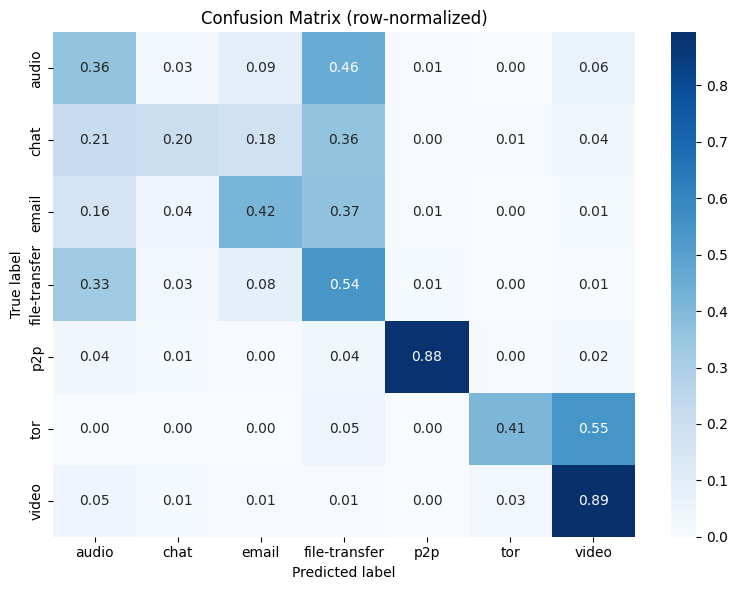

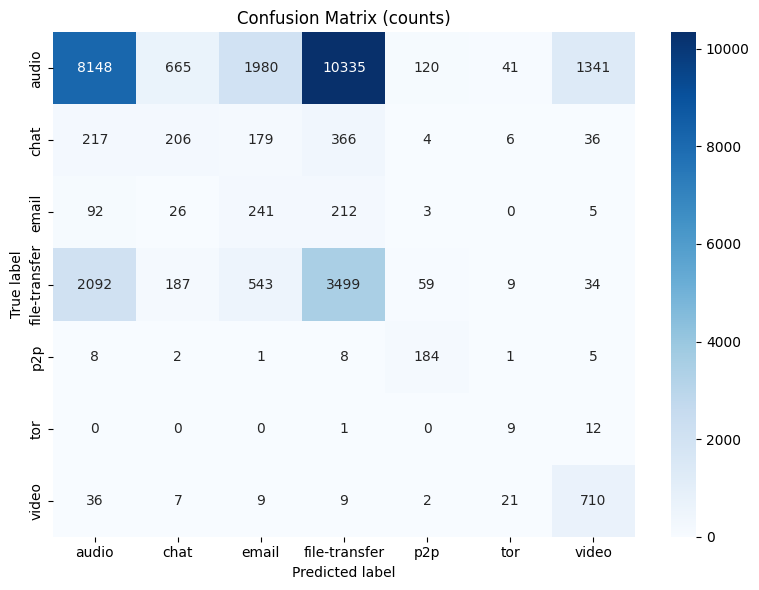


Top feature importances:
 1. total_bytes                     0.0495
 2. size_min                        0.0464
 3. size_q10                        0.0442
 4. log_total_bytes                 0.0422
 5. size_q25                        0.0368
 6. size_q90                        0.0319
 7. size_max                        0.0312
 8. bytes_per_pkt                   0.0259
 9. size_mean                       0.0251
10. iat_q10                         0.0247
11. size_median                     0.0244
12. size_q75                        0.0243
13. iat_min                         0.0240
14. size_cv                         0.0233
15. size_std_over_mean              0.0233
16. log_duration                    0.0229
17. prop_size_0_100                 0.0229
18. iat_q25                         0.0227
19. duration                        0.0221
20. iat_max                         0.0206


In [7]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ---------------------------------------------------------
# 1. Prepare features and labels
# ---------------------------------------------------------

# Assume df already exists in memory
label_cols = ["easy_label", "medium_label", "hard_label"]
id_cols = ["sampleID"] if "sampleID" in df.columns else []
drop_cols = set(label_cols + id_cols)

feature_cols = [c for c in df.columns if c not in drop_cols]
target_col = "easy_label"   # 7-class label

X = df[feature_cols].values
y_raw = df[target_col].astype(str).values

# Encode labels to integers
le = LabelEncoder()
y = le.fit_transform(y_raw)
class_names = le.classes_

print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])
print("Classes:", class_names)

# ---------------------------------------------------------
# 2. Train / test split (80/20, stratified)
# ---------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_SEED,
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# ---------------------------------------------------------
# 3. Random Forest hyperparameter search (lighter + multi-core)
# ---------------------------------------------------------

# IMPORTANT: n_jobs=1 here so CV can parallelize across cores via RandomizedSearchCV
rf_base = RandomForestClassifier(
    n_estimators=300,
    n_jobs=1,
    random_state=RANDOM_SEED,
    class_weight="balanced_subsample",
)

# Trimmed, sane search space (you can expand later if needed)
param_dist = {
    "n_estimators": [100, 200, 400, 600],          # no 800/1000 to start
    "max_depth": [None, 10, 20, 30],          # drop 40 for now
    "min_samples_split": [2, 5],              # fewer options
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.3, 0.5],       # no 0.7/log2 for now
    "bootstrap": [True],                      # drop False (expensive)
}

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=12,               # small to start; can increase if needed
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,               # parallelize across folds/params
    verbose=2,
    random_state=RANDOM_SEED,
)

print("\n=== Starting RandomizedSearchCV (light config) ===")
rf_search.fit(X_train, y_train)

print("\nBest params:", rf_search.best_params_)
print("Best CV macro F1:", rf_search.best_score_)

rf_best = rf_search.best_estimator_

# ---------------------------------------------------------
# 4. Evaluation on held-out test set
# ---------------------------------------------------------

y_pred = rf_best.predict(X_test)
y_proba = rf_best.predict_proba(X_test)

# F1 scores
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")
f1_micro = f1_score(y_test, y_pred, average="micro")

print(f"\nTest F1 (macro):   {f1_macro:.4f}")
print(f"Test F1 (weighted): {f1_weighted:.4f}")
print(f"Test F1 (micro):    {f1_micro:.4f}")

# mAP (macro)
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
mAP_macro = average_precision_score(y_test_bin, y_proba, average="macro")
print(f"Test mAP (macro):  {mAP_macro:.4f}")

print("\nClassification report (per class):")
print(classification_report(y_test, y_pred, target_names=class_names))

# ---------------------------------------------------------
# 5. Confusion matrix (normalized + counts)
# ---------------------------------------------------------

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (row-normalized)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (counts)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 6. Feature importance
# ---------------------------------------------------------

importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 20
print("\nTop feature importances:")
for i in range(min(top_k, len(feature_cols))):
    idx = indices[i]
    print(f"{i+1:2d}. {feature_cols[idx]:30s}  {importances[idx]:.4f}")


In [8]:
from sklearn.metrics import average_precision_score

# micro AP
map_micro = average_precision_score(y_test_bin, y_proba, average="micro")
print("Test mAP (micro):", map_micro)


Test mAP (micro): 0.4877378959109355


### Medium Label (18 classes)


=== Medium-level task ===
Number of samples: 158355
Number of features: 63
Num classes: 18
Classes: ['aim' 'email' 'facebook' 'ftps' 'gmail' 'google' 'hangouts' 'icq'
 'netflix' 'scp' 'sftp' 'skype' 'spotify' 'torrent' 'twitter' 'vimeo'
 'voipbuster' 'youtube']
Train size: 126684
Test size: 31671

=== Starting RandomizedSearchCV for medium_label ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END bootstrap=True, max_depth=20, max_features=0.3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  44.4s
[CV] END bootstrap=True, max_depth=30, max_features=0.3, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  44.7s
[CV] END bootstrap=True, max_depth=30, max_features=0.3, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  45.1s
[CV] END bootstrap=True, max_depth=20, max_features=0.3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  45.2s
[CV] END bootstrap=True, max_depth=30, max_feat

/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=30, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time= 3.3min
[CV] END bootstrap=True, max_depth=30, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time= 3.3min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  15.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  13.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  11.9s
[CV] END bootstrap=True, max_depth=20, max_features=0.3, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 1.5min
[CV] END bootstrap=True, max_depth=20, max_features=0.3, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 1.4min
[CV] END bootstrap=True, max_depth=20, max_features=

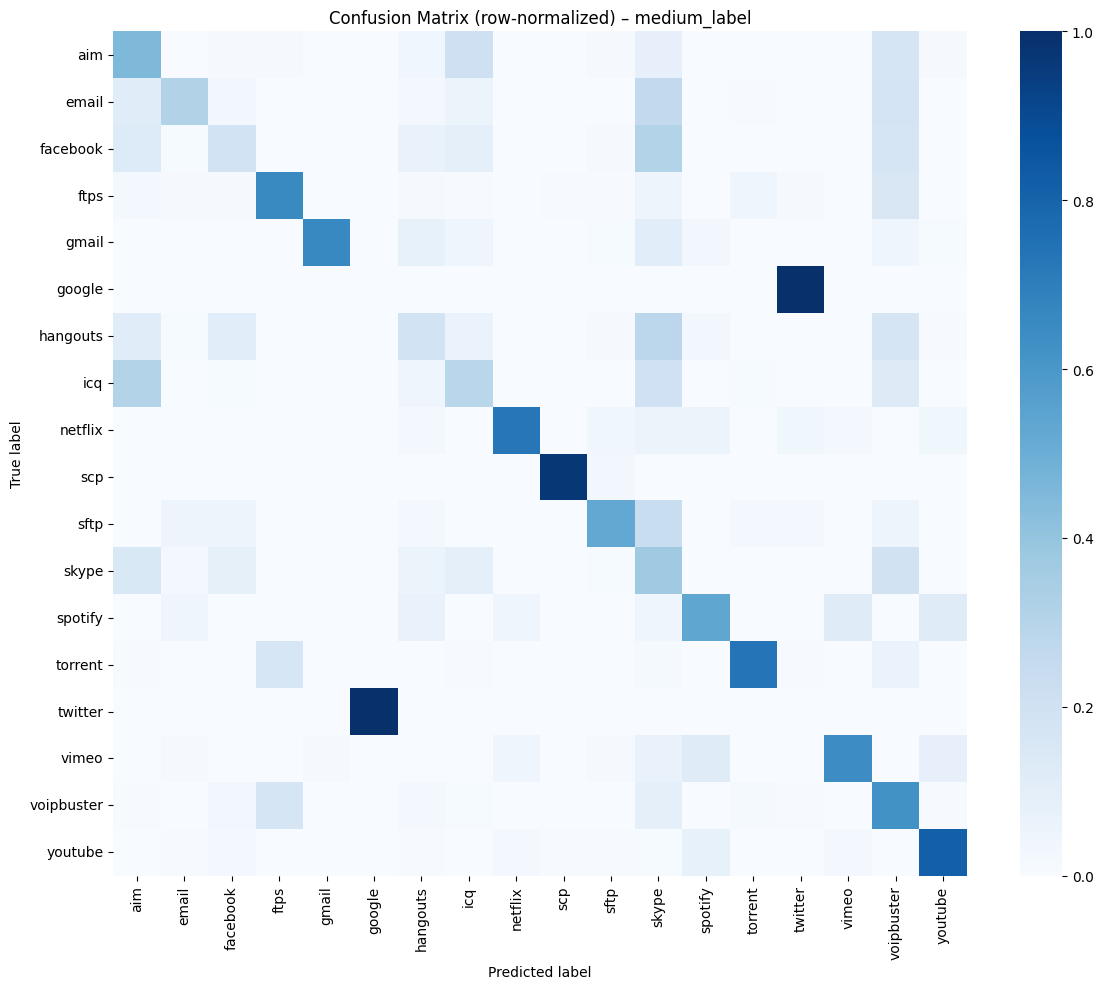


[Medium] Top feature importances:
 1. total_bytes                     0.0466
 2. log_total_bytes                 0.0465
 3. size_min                        0.0437
 4. size_q10                        0.0392
 5. size_q25                        0.0306
 6. size_q90                        0.0298
 7. size_max                        0.0270
 8. iat_median                      0.0261
 9. bytes_per_pkt                   0.0256
10. size_median                     0.0237
11. size_mean_over_max              0.0234
12. size_q75                        0.0230
13. duration                        0.0224
14. iat_mean                        0.0223
15. size_max_over_mean              0.0218
16. size_std_over_mean              0.0212
17. prop_size_0_100                 0.0206
18. iat_max                         0.0205
19. size_cv                         0.0202
20. size_mean                       0.0201


In [9]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ---------------------------------------------------------
# 1. Prepare features and labels for MEDIUM level
# ---------------------------------------------------------

# df is assumed to already include your engineered features
label_cols = ["easy_label", "medium_label", "hard_label"]
id_cols = ["sampleID"] if "sampleID" in df.columns else []
drop_cols = set(label_cols + id_cols)

feature_cols = [c for c in df.columns if c not in drop_cols]
target_col = "medium_label"   # 31-class label

X = df[feature_cols].values
y_raw = df[target_col].astype(str).values

# Encode labels
le_mid = LabelEncoder()
y = le_mid.fit_transform(y_raw)
class_names = le_mid.classes_

print("=== Medium-level task ===")
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])
print("Num classes:", len(class_names))
print("Classes:", class_names)

# ---------------------------------------------------------
# 2. Train / test split (80/20, stratified)
# ---------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_SEED,
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# ---------------------------------------------------------
# 3. Random Forest hyperparameter search (medium level)
# ---------------------------------------------------------

# Start near the good region we found for easy_label, but keep it light
rf_base = RandomForestClassifier(
    n_estimators=300,
    n_jobs=1,                     # let RandomizedSearchCV parallelize
    random_state=RANDOM_SEED,
    class_weight="balanced_subsample",
)

param_dist_mid = {
    "n_estimators": [100, 200, 400, 600],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.3],
    "bootstrap": [True],
}

rf_search_mid = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist_mid,
    n_iter=12,               # can bump to 20 if still fast enough
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_SEED,
)

print("\n=== Starting RandomizedSearchCV for medium_label ===")
rf_search_mid.fit(X_train, y_train)

print("\nBest params (medium):", rf_search_mid.best_params_)
print("Best CV macro F1 (medium):", rf_search_mid.best_score_)

rf_best_mid = rf_search_mid.best_estimator_

# ---------------------------------------------------------
# 4. Evaluation on held-out test set (medium level)
# ---------------------------------------------------------

y_pred = rf_best_mid.predict(X_test)
y_proba = rf_best_mid.predict_proba(X_test)

# F1 scores
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")
f1_micro = f1_score(y_test, y_pred, average="micro")

print(f"\n[Medium] Test F1 (macro):   {f1_macro:.4f}")
print(f"[Medium] Test F1 (weighted): {f1_weighted:.4f}")
print(f"[Medium] Test F1 (micro):    {f1_micro:.4f}")

# mAP (macro)
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
mAP_macro = average_precision_score(y_test_bin, y_proba, average="macro")
print(f"[Medium] Test mAP (macro):  {mAP_macro:.4f}")

print("\n[Medium] Classification report (per class):")
print(classification_report(y_test, y_pred, target_names=class_names))

# ---------------------------------------------------------
# 5. Confusion matrix (might be large: 31x31)
# ---------------------------------------------------------

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_norm,
    annot=False,  # True will be tiny; turn on if you zoom
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (row-normalized) – medium_label")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 6. Feature importance for medium level
# ---------------------------------------------------------

importances = rf_best_mid.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 20
print("\n[Medium] Top feature importances:")
for i in range(min(top_k, len(feature_cols))):
    idx = indices[i]
    print(f"{i+1:2d}. {feature_cols[idx]:30s}  {importances[idx]:.4f}")


### Hard Label (31 classes)


=== Hard-level task ===
Number of samples: 158355
Number of features: 63
Num classes: 31
Classes: ['aim-chat' 'email' 'facebook-audio' 'facebook-chat' 'facebook-video'
 'ftps-down' 'ftps-up' 'gmail-chat' 'hangouts-audio' 'hangouts-chat'
 'hangouts-video' 'icq-chat' 'netflix' 'scp-down' 'scp-up' 'sftp-down'
 'sftp-up' 'skype-audio' 'skype-chat' 'skype-file' 'skype-video' 'spotify'
 'tor-facebook' 'tor-google' 'tor-twitter' 'tor-vimeo' 'tor-youtube'
 'torrent' 'vimeo' 'voipbuster' 'youtube']
Train size: 126684
Test size: 31671

=== Starting RandomizedSearchCV for hard_label ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END bootstrap=True, max_depth=30, max_features=0.3, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  30.5s
[CV] END bootstrap=True, max_depth=20, max_features=0.3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  31.2s
[CV] END bootstrap=True, max_depth=20, max_features=0.3, min_samples_leaf=1, min_sampl

/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=0.3, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=0.3, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time= 1.2min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time= 1.2min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  12.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  12.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  13.0s
[CV] END bootstrap=True, max_depth=10, max_fea

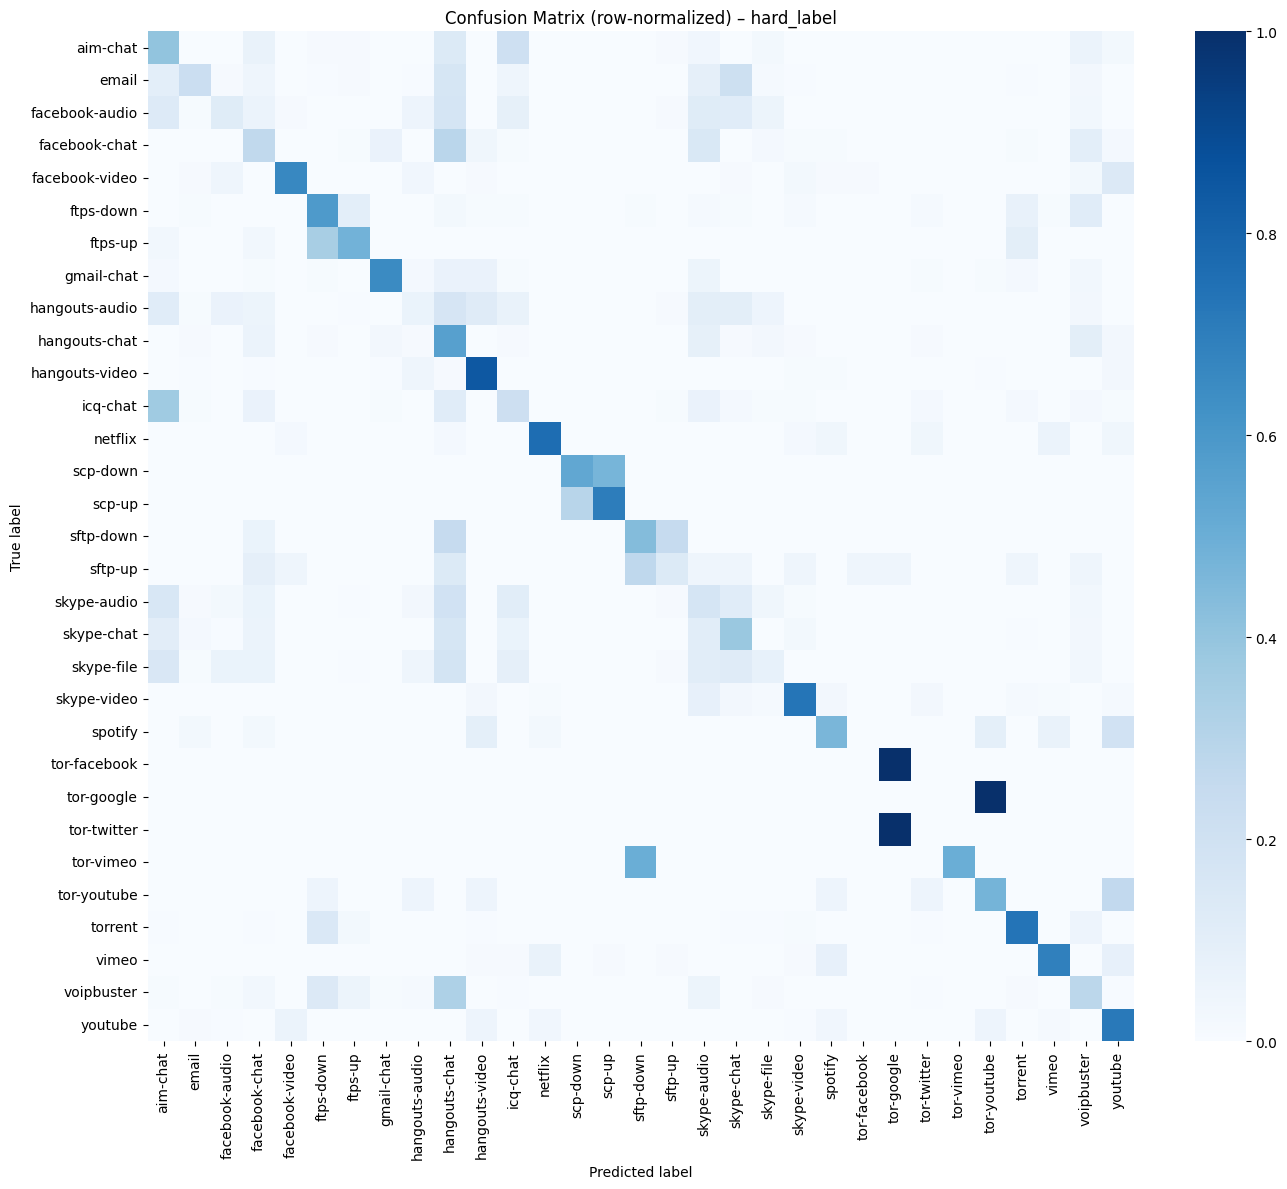


[Hard] Top feature importances:
 1. total_bytes                     0.0441
 2. size_min                        0.0409
 3. log_total_bytes                 0.0391
 4. size_q10                        0.0312
 5. size_q25                        0.0267
 6. size_std_over_mean              0.0253
 7. size_q90                        0.0245
 8. size_std                        0.0244
 9. duration                        0.0241
10. size_cv                         0.0240
11. bytes_per_pkt                   0.0236
12. size_max                        0.0235
13. iat_mean                        0.0226
14. size_q75                        0.0225
15. log_duration                    0.0222
16. size_mean_over_max              0.0217
17. size_iqr                        0.0212
18. iat_median                      0.0208
19. size_max_over_mean              0.0206
20. size_median                     0.0203


In [10]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ---------------------------------------------------------
# 1. Prepare features and labels for HARD level
# ---------------------------------------------------------

# df is assumed to already include your engineered features
label_cols = ["easy_label", "medium_label", "hard_label"]
id_cols = ["sampleID"] if "sampleID" in df.columns else []
drop_cols = set(label_cols + id_cols)

feature_cols = [c for c in df.columns if c not in drop_cols]
target_col = "hard_label"   # fine-grained label

X = df[feature_cols].values
y_raw = df[target_col].astype(str).values

# Encode hard labels
le_hard = LabelEncoder()
y = le_hard.fit_transform(y_raw)
class_names = le_hard.classes_

print("=== Hard-level task ===")
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])
print("Num classes:", len(class_names))
print("Classes:", class_names)

# ---------------------------------------------------------
# 2. Train / test split (80/20, stratified)
# ---------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_SEED,
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# ---------------------------------------------------------
# 3. Random Forest hyperparameter search (HARD level)
# ---------------------------------------------------------

# Hard level is very imbalanced; keep class_weight on
rf_base = RandomForestClassifier(
    n_estimators=300,
    n_jobs=1,                     # let RandomizedSearchCV parallelize
    random_state=RANDOM_SEED,
    class_weight="balanced_subsample",
)

param_dist_hard = {
    "n_estimators": [100,200, 400, 600],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.3],
    "bootstrap": [True],
}

rf_search_hard = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist_hard,
    n_iter=12,               # bump to 20 if you want, once you see runtime
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_SEED,
)

print("\n=== Starting RandomizedSearchCV for hard_label ===")
rf_search_hard.fit(X_train, y_train)

print("\nBest params (hard):", rf_search_hard.best_params_)
print("Best CV macro F1 (hard):", rf_search_hard.best_score_)

rf_best_hard = rf_search_hard.best_estimator_

# ---------------------------------------------------------
# 4. Evaluation on held-out test set (hard level)
# ---------------------------------------------------------

y_pred = rf_best_hard.predict(X_test)
y_proba = rf_best_hard.predict_proba(X_test)

# F1 scores
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")
f1_micro = f1_score(y_test, y_pred, average="micro")

print(f"\n[Hard] Test F1 (macro):   {f1_macro:.4f}")
print(f"[Hard] Test F1 (weighted): {f1_weighted:.4f}")
print(f"[Hard] Test F1 (micro):    {f1_micro:.4f}")

# mAP (macro)
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
mAP_macro = average_precision_score(y_test_bin, y_proba, average="macro")
print(f"[Hard] Test mAP (macro):  {mAP_macro:.4f}")

print("\n[Hard] Classification report (per class):")
print(classification_report(y_test, y_pred, target_names=class_names))

# ---------------------------------------------------------
# 5. Confusion matrix (can be big; you may want to subset to top classes)
# ---------------------------------------------------------

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_norm,
    annot=False,  # True gets unreadable with many classes
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (row-normalized) – hard_label")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 6. Feature importance for hard level
# ---------------------------------------------------------

importances = rf_best_hard.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 20
print("\n[Hard] Top feature importances:")
for i in range(min(top_k, len(feature_cols))):
    idx = indices[i]
    print(f"{i+1:2d}. {feature_cols[idx]:30s}  {importances[idx]:.4f}")


## SVM with Regular Dataset


In [11]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (
    f1_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
)


def netml_split_80_10_10(y, random_state=0):
    """
    Implement the NetML style split:
      - For each class separately:
        * randomly select 10 percent of samples to test_chal
        * randomly select 10 percent to test_std
        * remaining 80 percent to train
    Returns three index arrays: idx_train, idx_test_std, idx_test_chal
    """
    rng = np.random.RandomState(random_state)
    y = np.asarray(y)
    unique_classes = np.unique(y)

    idx_train = []
    idx_test_std = []
    idx_test_chal = []

    for cls in unique_classes:
        cls_idx = np.where(y == cls)[0]
        n = len(cls_idx)
        # shuffle indices for this class
        perm = rng.permutation(cls_idx)

        # number for each split (floor so small classes can end up with zero in a test split)
        n_chal = int(0.1 * n)
        n_std = int(0.1 * n)

        chal_idx = perm[:n_chal]
        std_idx = perm[n_chal:n_chal + n_std]
        train_idx = perm[n_chal + n_std:]

        idx_test_chal.append(chal_idx)
        idx_test_std.append(std_idx)
        idx_train.append(train_idx)

    idx_train = np.concatenate(idx_train)
    idx_test_std = np.concatenate(idx_test_std)
    idx_test_chal = np.concatenate(idx_test_chal)

    return idx_train, idx_test_std, idx_test_chal


def train_eval_svm_for_label(df, feature_cols, label_col, random_state=0):
    """
    Match the paper:
      - Per class 80 percent train, 10 percent test_std, 10 percent test_chal
      - Only 10 percent of the training set is used to fit SVM, remaining 90 percent is validation
      - RBF SVM with C = 1.0, gamma = 'scale'
      - Report F1 (macro, weighted, micro) and mAP (macro) on validation and test_std
    """

    # 1. Build X, y
    X = df[feature_cols].values
    y = df[label_col].values

    # 2. NetML style 80 / 10 / 10 split per class
    idx_train, idx_test_std, idx_test_chal = netml_split_80_10_10(y, random_state=random_state)

    X_train_full = X[idx_train]
    y_train_full = y[idx_train]

    X_test_std = X[idx_test_std]
    y_test_std = y[idx_test_std]

    X_test_chal = X[idx_test_chal]
    y_test_chal = y[idx_test_chal]

    print(f"[{label_col}] total samples: {len(df)}")
    print(
        f"[{label_col}] train: {len(X_train_full)}, "
        f"test_std: {len(X_test_std)}, "
        f"test_chal: {len(X_test_chal)}"
    )

    # 3. Inside training set, take random 10 percent for fitting SVM, 90 percent for validation
    rng = np.random.RandomState(random_state)
    n_train = len(X_train_full)
    n_fit = max(1, int(0.1 * n_train))

    perm_train = rng.permutation(n_train)
    idx_fit_local = perm_train[:n_fit]
    idx_val_local = perm_train[n_fit:]

    X_fit = X_train_full[idx_fit_local]
    y_fit = y_train_full[idx_fit_local]

    X_val = X_train_full[idx_val_local]
    y_val = y_train_full[idx_val_local]

    print(f"[{label_col}] SVM fit subset: {len(X_fit)} (10 percent of train)")
    print(f"[{label_col}] validation subset: {len(X_val)} (90 percent of train)")

    # 4. SVM pipeline: StandardScaler + RBF SVM
    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(
            kernel="rbf",
            C=1.0,
            gamma="scale",
            probability=True,  # needed for mAP
        )),
    ])

    # 5. Train on the 10 percent fit subset
    svm_clf.fit(X_fit, y_fit)

    def compute_metrics(model, X_split, y_split, split_name):
        """
        Compute F1 macro, weighted, micro and mAP macro for a split.
        """
        y_pred = model.predict(X_split)

        f1_macro = f1_score(y_split, y_pred, average="macro")
        f1_weighted = f1_score(y_split, y_pred, average="weighted")
        f1_micro = f1_score(y_split, y_pred, average="micro")

        # mAP (macro) one versus rest
        classes = np.unique(y_fit)  # classes seen in training
        y_true_bin = label_binarize(y_split, classes=classes)
        y_scores = model.predict_proba(X_split)

        # Some classes might not appear in this split; average="macro" handles that
        mAP_macro = average_precision_score(y_true_bin, y_scores, average="macro")

        print(f"\n[{label_col}] {split_name} F1 (macro):     {f1_macro:.4f}")
        print(f"[{label_col}] {split_name} F1 (weighted):  {f1_weighted:.4f}")
        print(f"[{label_col}] {split_name} F1 (micro):     {f1_micro:.4f}")
        print(f"[{label_col}] {split_name} mAP (macro):    {mAP_macro:.4f}")

        return {
            "f1_macro": f1_macro,
            "f1_weighted": f1_weighted,
            "f1_micro": f1_micro,
            "mAP_macro": mAP_macro,
            "y_pred": y_pred,
        }

    # 6. Metrics on validation and test_std
    val_metrics = compute_metrics(svm_clf, X_val, y_val, "validation")
    test_std_metrics = compute_metrics(svm_clf, X_test_std, y_test_std, "test_std")

    print("\nValidation classification report:")
    print(classification_report(y_val, val_metrics["y_pred"]))

    print("\nTest_std classification report:")
    print(classification_report(y_test_std, test_std_metrics["y_pred"]))

    cm_test_std = confusion_matrix(y_test_std, test_std_metrics["y_pred"])

    return {
        "model": svm_clf,
        "idx_train": idx_train,
        "idx_test_std": idx_test_std,
        "idx_test_chal": idx_test_chal,
        "X_fit": X_fit,
        "y_fit": y_fit,
        "X_val": X_val,
        "y_val": y_val,
        "X_test_std": X_test_std,
        "y_test_std": y_test_std,
        "X_test_chal": X_test_chal,
        "y_test_chal": y_test_chal,
        "val_metrics": val_metrics,
        "test_std_metrics": test_std_metrics,
        "cm_test_std": cm_test_std,
    }


### Easy Label (7 classes)


In [12]:
res_easy = train_eval_svm_for_label(df, feature_cols, "easy_label")


[easy_label] total samples: 158355
[easy_label] train: 126691, test_std: 15832, test_chal: 15832
[easy_label] SVM fit subset: 12669 (10 percent of train)
[easy_label] validation subset: 114022 (90 percent of train)

[easy_label] validation F1 (macro):     0.2415
[easy_label] validation F1 (weighted):  0.6165
[easy_label] validation F1 (micro):     0.7220
[easy_label] validation mAP (macro):    0.2885

[easy_label] test_std F1 (macro):     0.2310
[easy_label] test_std F1 (weighted):  0.6149
[easy_label] test_std F1 (micro):     0.7211
[easy_label] test_std mAP (macro):    0.2854

Validation classification report:


/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


               precision    recall  f1-score   support

        audio       0.72      1.00      0.84     81459
         chat       0.93      0.07      0.13      3652
        email       0.74      0.06      0.10      2084
file-transfer       0.75      0.01      0.01     23144
          p2p       0.67      0.19      0.30       764
          tor       0.00      0.00      0.00        76
        video       0.52      0.23      0.32      2843

     accuracy                           0.72    114022
    macro avg       0.62      0.22      0.24    114022
 weighted avg       0.73      0.72      0.62    114022


Test_std classification report:
               precision    recall  f1-score   support

        audio       0.72      0.99      0.84     11315
         chat       0.97      0.06      0.12       507
        email       0.72      0.04      0.08       289
file-transfer       1.00      0.01      0.01      3211
          p2p       0.73      0.18      0.29       104
          tor       0.00    

/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

### Medium Label (18 classes)


In [13]:
res_medium = train_eval_svm_for_label(df, feature_cols, "medium_label")


[medium_label] total samples: 158355
[medium_label] train: 126701, test_std: 15827, test_chal: 15827
[medium_label] SVM fit subset: 12670 (10 percent of train)
[medium_label] validation subset: 114031 (90 percent of train)

[medium_label] validation F1 (macro):     0.1722
[medium_label] validation F1 (weighted):  0.3434
[medium_label] validation F1 (micro):     0.4251
[medium_label] validation mAP (macro):    0.2373

[medium_label] test_std F1 (macro):     0.1875
[medium_label] test_std F1 (weighted):  0.3472
[medium_label] test_std F1 (micro):     0.4274
[medium_label] test_std mAP (macro):    0.2446

Validation classification report:


/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

         aim       0.00      0.00      0.00       290
       email       0.89      0.05      0.10      2088
    facebook       0.47      0.13      0.20     31993
        ftps       0.40      0.21      0.27       532
       gmail       0.86      0.43      0.57       317
      google       0.00      0.00      0.00         5
    hangouts       0.74      0.16      0.26     34155
         icq       0.00      0.00      0.00       322
     netflix       1.00      0.01      0.02       183
         scp       0.00      0.00      0.00       119
        sftp       1.00      0.12      0.21       142
       skype       0.40      0.95      0.56     39999
     spotify       0.40      0.01      0.03       153
     torrent       0.68      0.10      0.18       756
     twitter       0.00      0.00      0.00         6
       vimeo       0.53      0.17      0.26       302
  voipbuster       0.44      0.19      0.26      1990
     youtube       0.27    

/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

### Hard Label (31 classes)


In [14]:
res_hard = train_eval_svm_for_label(df, feature_cols, "hard_label")


[hard_label] total samples: 158355
[hard_label] train: 126715, test_std: 15820, test_chal: 15820
[hard_label] SVM fit subset: 12671 (10 percent of train)
[hard_label] validation subset: 114044 (90 percent of train)

[hard_label] validation F1 (macro):     0.1188
[hard_label] validation F1 (weighted):  0.2424
[hard_label] validation F1 (micro):     0.3182
[hard_label] validation mAP (macro):    0.1466


/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1131: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



[hard_label] test_std F1 (macro):     0.1251
[hard_label] test_std F1 (weighted):  0.2453
[hard_label] test_std F1 (micro):     0.3218
[hard_label] test_std mAP (macro):    0.1556

Validation classification report:


/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                precision    recall  f1-score   support

      aim-chat       0.00      0.00      0.00       290
         email       0.45      0.07      0.12      2088
facebook-audio       0.31      0.51      0.38     31344
 facebook-chat       0.70      0.12      0.21       371
facebook-video       1.00      0.02      0.04       295
     ftps-down       0.44      0.12      0.19       443
       ftps-up       0.57      0.04      0.07       100
    gmail-chat       0.99      0.51      0.67       325
hangouts-audio       0.32      0.58      0.41     32789
 hangouts-chat       0.00      0.00      0.00       243
hangouts-video       0.12      0.01      0.02      1047
      icq-chat       0.00      0.00      0.00       312
       netflix       0.00      0.00      0.00       187
      scp-down       0.00      0.00      0.00        63
        scp-up       0.00      0.00      0.00        64
     sftp-down       0.00      0.00      0.00        59
       sftp-up       1.00      0.01      0.02  

/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

## MLP with Regular Dataset


In [15]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    f1_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


def train_eval_mlp_for_label(df, feature_cols, label_col, random_state=42):
    """
    MLP experiment following NetML paper methodology:
    - 121 hidden units
    - L2 regularization (alpha = 0.0001)
    - Adam optimizer
    - StandardScaler preprocessing
    - 80/20 train/test split (stratified)
    
    Reports F1 (macro, weighted, micro) and mAP (macro) on test set.
    """
    
    # 1. Build X, y
    X = df[feature_cols].values
    y_raw = df[label_col].astype(str).values
    
    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
    class_names = le.classes_
    
    print(f"\n{'='*60}")
    print(f"MLP Classification for: {label_col}")
    print(f"{'='*60}")
    print(f"Number of samples: {X.shape[0]}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Classes: {class_names}")
    
    # 2. Train/test split (80/20, stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=random_state,
    )
    
    print(f"Train size: {X_train.shape[0]}")
    print(f"Test size: {X_test.shape[0]}")
    
    # 3. Standardize features (paper: "data is standardized so that 
    #    each feature column follows standard normal distribution")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 4. MLP Classifier with paper parameters
    mlp = MLPClassifier(
        hidden_layer_sizes=(121,),  # Single hidden layer with 121 units
        alpha=0.0001,               # L2 regularization
        solver='adam',              # Adam optimizer
        max_iter=500,               # Increase if not converging
        random_state=random_state,
        early_stopping=True,        # Use validation for early stopping
        validation_fraction=0.1,
        n_iter_no_change=20,
        verbose=False,
    )
    
    print("\nTraining MLP...")
    mlp.fit(X_train_scaled, y_train)
    print(f"Training completed in {mlp.n_iter_} iterations")
    
    # 5. Predictions
    y_pred = mlp.predict(X_test_scaled)
    y_proba = mlp.predict_proba(X_test_scaled)
    
    # 6. Compute metrics
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    
    # mAP (macro) - one-vs-rest
    y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
    mAP_macro = average_precision_score(y_test_bin, y_proba, average="macro")
    
    print(f"\n--- Results for {label_col} ---")
    print(f"Test F1 (macro):    {f1_macro:.4f}")
    print(f"Test F1 (weighted): {f1_weighted:.4f}")
    print(f"Test F1 (micro):    {f1_micro:.4f}")
    print(f"Test mAP (macro):   {mAP_macro:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # 7. Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    
    # Plot normalized confusion matrix
    fig_size = (8, 6) if len(class_names) <= 10 else (12, 10)
    plt.figure(figsize=fig_size)
    sns.heatmap(
        cm_norm,
        annot=len(class_names) <= 10,
        fmt=".2f" if len(class_names) <= 10 else "",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"MLP Confusion Matrix (normalized) - {label_col}")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return {
        "model": mlp,
        "scaler": scaler,
        "label_encoder": le,
        "class_names": class_names,
        "X_train": X_train_scaled,
        "X_test": X_test_scaled,
        "y_train": y_train,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "f1_micro": f1_micro,
        "mAP_macro": mAP_macro,
        "cm": cm,
        "cm_norm": cm_norm,
    }


print("MLP helper function defined successfully!")

MLP helper function defined successfully!


### Easy Label (7 classes)


Using 63 features for MLP
Dataframe shape: (158355, 67)

MLP Classification for: easy_label
Number of samples: 158355
Number of features: 63
Number of classes: 7
Classes: ['audio' 'chat' 'email' 'file-transfer' 'p2p' 'tor' 'video']
Train size: 126684
Test size: 31671

Training MLP...
Training completed in 124 iterations

--- Results for easy_label ---
Test F1 (macro):    0.3916
Test F1 (weighted): 0.6370
Test F1 (micro):    0.7330
Test mAP (macro):   0.4358

Classification Report:
               precision    recall  f1-score   support

        audio       0.74      0.99      0.84     22630
         chat       0.67      0.20      0.30      1014
        email       0.65      0.15      0.24       579
file-transfer       0.65      0.01      0.02      6423
          p2p       0.73      0.59      0.65       209
          tor       0.60      0.14      0.22        22
        video       0.66      0.35      0.46       794

     accuracy                           0.73     31671
    macro avg    

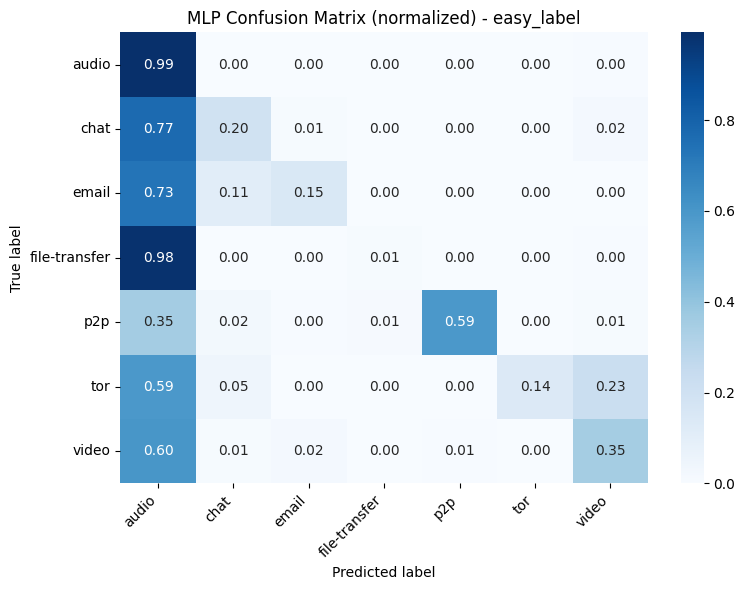


Comparison with Paper Baseline (easy_label / top-level):
Paper:  F1=0.6066, mAP=0.2304
Ours:   F1=0.3916, mAP=0.4358


In [16]:
# MLP for easy_label (top-level, 7 classes)
# Paper baseline: F1=0.6066, mAP=0.2304

# Ensure we have the correct dataframe with labels
# If df doesn't have labels, try to use full_df or reload from CSV
label_cols = ["easy_label", "medium_label", "hard_label"]

# Check if current df has labels, if not try alternatives
if "easy_label" not in df.columns:
    print("Warning: df doesn't have labels. Trying to recover...")
    if 'full_df' in dir() and "easy_label" in full_df.columns:
        # Use full_df if available
        print("Using full_df...")
        df_mlp = full_df.copy()
    else:
        # Try loading from saved CSV
        print("Loading from application_id_dataset.csv...")
        import pandas as pd
        df_mlp = pd.read_csv("application_id_dataset.csv")
else:
    df_mlp = df

# Define feature columns (exclude labels and ID)
id_cols = ["sampleID"] if "sampleID" in df_mlp.columns else []
drop_cols = set(label_cols + id_cols)
feature_cols = [c for c in df_mlp.columns if c not in drop_cols]

print(f"Using {len(feature_cols)} features for MLP")
print(f"Dataframe shape: {df_mlp.shape}")

mlp_easy_results = train_eval_mlp_for_label(
    df=df_mlp,
    feature_cols=feature_cols,
    label_col="easy_label",
    random_state=RANDOM_SEED,
)

print("\n" + "="*60)
print("Comparison with Paper Baseline (easy_label / top-level):")
print("="*60)
print(f"Paper:  F1={0.6066:.4f}, mAP={0.2304:.4f}")
print(f"Ours:   F1={mlp_easy_results['f1_macro']:.4f}, mAP={mlp_easy_results['mAP_macro']:.4f}")

### Medium Label (18 classes)



MLP Classification for: medium_label
Number of samples: 158355
Number of features: 63
Number of classes: 18
Classes: ['aim' 'email' 'facebook' 'ftps' 'gmail' 'google' 'hangouts' 'icq'
 'netflix' 'scp' 'sftp' 'skype' 'spotify' 'torrent' 'twitter' 'vimeo'
 'voipbuster' 'youtube']
Train size: 126684
Test size: 31671

Training MLP...
Training completed in 115 iterations

--- Results for medium_label ---
Test F1 (macro):    0.3265
Test F1 (weighted): 0.3648
Test F1 (micro):    0.4411
Test mAP (macro):   0.3378

Classification Report:
              precision    recall  f1-score   support

         aim       0.40      0.02      0.05        82
       email       0.77      0.15      0.25       580
    facebook       0.51      0.14      0.21      8873
        ftps       0.51      0.18      0.27       150
       gmail       0.83      0.49      0.62        89
      google       0.00      0.00      0.00         1
    hangouts       0.82      0.17      0.27      9486
         icq       0.25      0.

/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

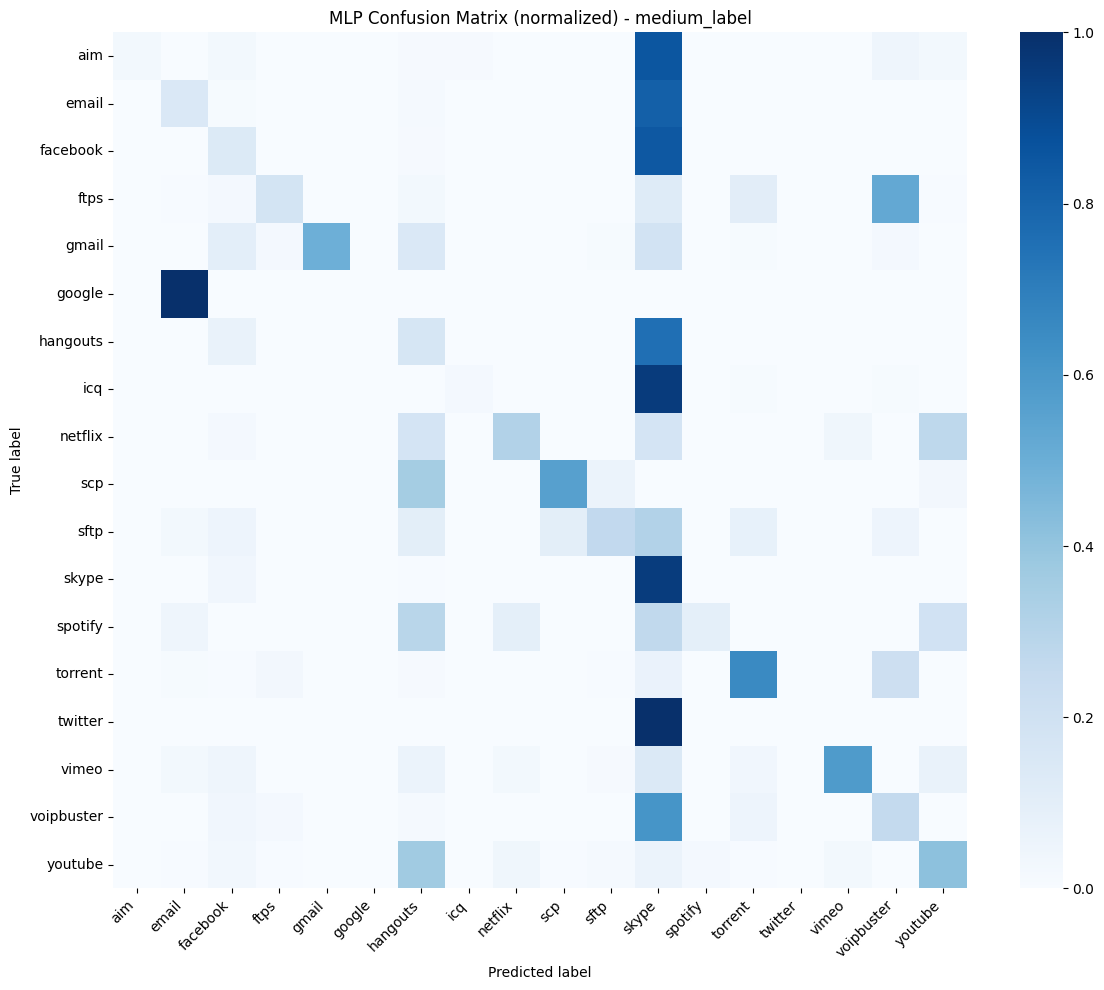


Comparison with Paper Baseline (medium_label / mid-level):
Paper:  F1=0.3609, mAP=0.2041
Ours:   F1=0.3265, mAP=0.3378


In [17]:
# MLP for medium_label (mid-level, 18 classes)
# Paper baseline: F1=0.3609, mAP=0.2041

# Use df_mlp from the previous cell (or recreate if needed)
if 'df_mlp' not in dir():
    label_cols = ["easy_label", "medium_label", "hard_label"]
    if "easy_label" not in df.columns:
        if 'full_df' in dir() and "easy_label" in full_df.columns:
            df_mlp = full_df.copy()
        else:
            import pandas as pd
            df_mlp = pd.read_csv("application_id_dataset.csv")
    else:
        df_mlp = df
    id_cols = ["sampleID"] if "sampleID" in df_mlp.columns else []
    drop_cols = set(label_cols + id_cols)
    feature_cols = [c for c in df_mlp.columns if c not in drop_cols]

mlp_medium_results = train_eval_mlp_for_label(
    df=df_mlp,
    feature_cols=feature_cols,
    label_col="medium_label",
    random_state=RANDOM_SEED,
)

print("\n" + "="*60)
print("Comparison with Paper Baseline (medium_label / mid-level):")
print("="*60)
print(f"Paper:  F1={0.3609:.4f}, mAP={0.2041:.4f}")
print(f"Ours:   F1={mlp_medium_results['f1_macro']:.4f}, mAP={mlp_medium_results['mAP_macro']:.4f}")

### Hard Label (31 classes)



MLP Classification for: hard_label
Number of samples: 158355
Number of features: 63
Number of classes: 31
Classes: ['aim-chat' 'email' 'facebook-audio' 'facebook-chat' 'facebook-video'
 'ftps-down' 'ftps-up' 'gmail-chat' 'hangouts-audio' 'hangouts-chat'
 'hangouts-video' 'icq-chat' 'netflix' 'scp-down' 'scp-up' 'sftp-down'
 'sftp-up' 'skype-audio' 'skype-chat' 'skype-file' 'skype-video' 'spotify'
 'tor-facebook' 'tor-google' 'tor-twitter' 'tor-vimeo' 'tor-youtube'
 'torrent' 'vimeo' 'voipbuster' 'youtube']
Train size: 126684
Test size: 31671

Training MLP...
Training completed in 94 iterations

--- Results for hard_label ---
Test F1 (macro):    0.2367
Test F1 (weighted): 0.2678
Test F1 (micro):    0.3369
Test mAP (macro):   0.2998

Classification Report:
                precision    recall  f1-score   support

      aim-chat       0.00      0.00      0.00        82
         email       0.54      0.15      0.24       580
facebook-audio       0.33      0.48      0.39      8691
 facebook

/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

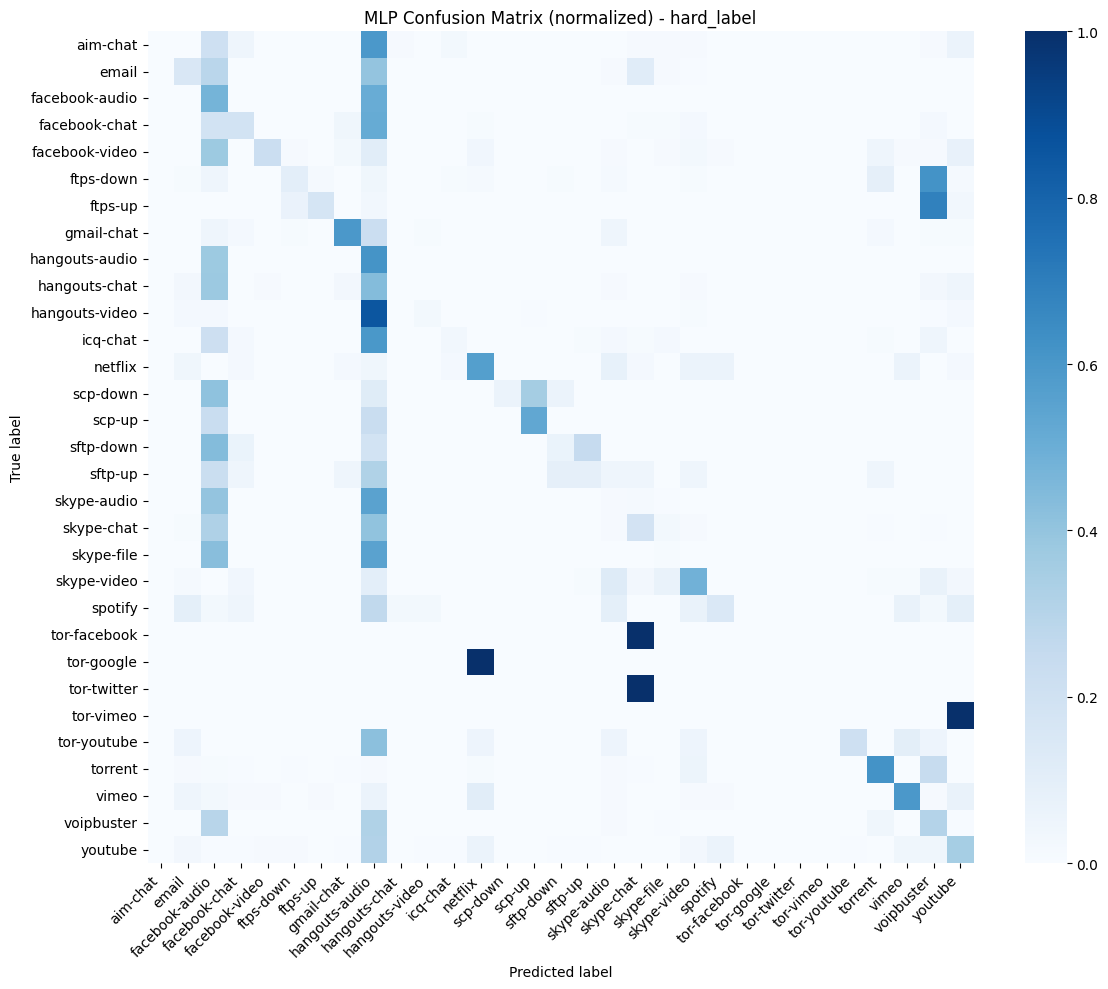


Comparison with Paper Baseline (hard_label / fine-grained):
Paper:  F1=0.2359, mAP=0.1404
Ours:   F1=0.2367, mAP=0.2998


In [18]:
# MLP for hard_label (fine-grained, 31 classes)
# Paper baseline: F1=0.2359, mAP=0.1404

# Use df_mlp from the previous cells (or recreate if needed)
if 'df_mlp' not in dir():
    label_cols = ["easy_label", "medium_label", "hard_label"]
    if "easy_label" not in df.columns:
        if 'full_df' in dir() and "easy_label" in full_df.columns:
            df_mlp = full_df.copy()
        else:
            import pandas as pd
            df_mlp = pd.read_csv("application_id_dataset.csv")
    else:
        df_mlp = df
    id_cols = ["sampleID"] if "sampleID" in df_mlp.columns else []
    drop_cols = set(label_cols + id_cols)
    feature_cols = [c for c in df_mlp.columns if c not in drop_cols]

mlp_hard_results = train_eval_mlp_for_label(
    df=df_mlp,
    feature_cols=feature_cols,
    label_col="hard_label",
    random_state=RANDOM_SEED,
)

print("\n" + "="*60)
print("Comparison with Paper Baseline (hard_label / fine-grained):")
print("="*60)
print(f"Paper:  F1={0.2359:.4f}, mAP={0.1404:.4f}")
print(f"Ours:   F1={mlp_hard_results['f1_macro']:.4f}, mAP={mlp_hard_results['mAP_macro']:.4f}")

## Loading nPrint Data


In [19]:
import pandas as pd
import pcapml_fe
from pathlib import Path

# Step 1: Extract flow-level labels with flow_id
flow_label_rows = []

for tsample in pcapml_fe.sampler(str(PCAP_PATH)):
    meta = str(tsample.metadata).strip()
    parts = meta.split("_")
    if len(parts) != 3:
        raise ValueError(f"Unexpected metadata format for sample {tsample.sid}: {meta}")
    easy_lbl, med_lbl, hard_lbl = parts
    
    flow_label_rows.append({
        "flow_id": str(tsample.sid),
        "easy_label": easy_lbl,
        "medium_label": med_lbl,
        "hard_label": hard_lbl,
    })

flow_labels_df = pd.DataFrame(flow_label_rows)
print("Flow labels shape:", flow_labels_df.shape)

# Step 2: Load all nprint CSVs
dfs = []
for csv_file in Path("nprint_outputs").glob("*.csv"):
    df = pd.read_csv(csv_file)
    stem = csv_file.stem  # e.g., "12962054460325634226_audio_facebook"
    flow_id = stem.split("_")[0]  # Take only the numeric ID
    df["flow_id"] = flow_id
    dfs.append(df)

nprint_df = pd.concat(dfs, ignore_index=True)
print("nPrint features shape:", nprint_df.shape)

# Step 3: Join features with labels
final_df = nprint_df.merge(flow_labels_df, on="flow_id", how="left")
print("Final shape:", final_df.shape)
print(final_df.head())

# Check for NaN labels
print("NaN labels:", final_df["easy_label"].isna().sum())

Flow labels shape: (158355, 4)
nPrint features shape: (7834, 1778)
Final shape: (7834, 1781)
           src_ip  eth_dhost_0  eth_dhost_1  eth_dhost_2  eth_dhost_3  \
0  131.202.240.87            0            0            0            0   
1  131.202.240.87            0            0            0            0   
2  131.202.242.93            0            0            0            0   
3  131.202.242.93            0            0            0            0   
4  131.202.242.93            0            0            0            0   

   eth_dhost_4  eth_dhost_5  eth_dhost_6  eth_dhost_7  eth_dhost_8  ...  \
0            0            0            0            1            0  ...   
1            0            0            0            1            0  ...   
2            0            0            0            1            0  ...   
3            0            0            0            1            0  ...   
4            0            0            0            1            0  ...   

   payload_bit_25

## Random Forest with nPrint


In [20]:
# Step 0: Prepare features (run once)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, average_precision_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Drop non-feature columns
X = final_df.drop(columns=["flow_id", "easy_label", "medium_label", "hard_label", "src_ip"])

# Handle any remaining NaN in features
X = X.fillna(-1)

print("Features shape:", X.shape)

Features shape: (7834, 1776)


### Easy Label (7 classes)


Easy Label - F1 Score (weighted): 0.7891
Easy Label - mAP: 0.7761

Classification Report:
               precision    recall  f1-score   support

        audio       0.79      0.99      0.88       992
         chat       0.89      0.46      0.60        35
        email       0.96      0.89      0.92        54
file-transfer       0.97      0.25      0.39       296
          p2p       0.97      0.97      0.97        92
          tor       0.00      0.00      0.00         1
        video       0.96      0.84      0.90        97

     accuracy                           0.83      1567
    macro avg       0.79      0.63      0.67      1567
 weighted avg       0.85      0.83      0.79      1567



/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

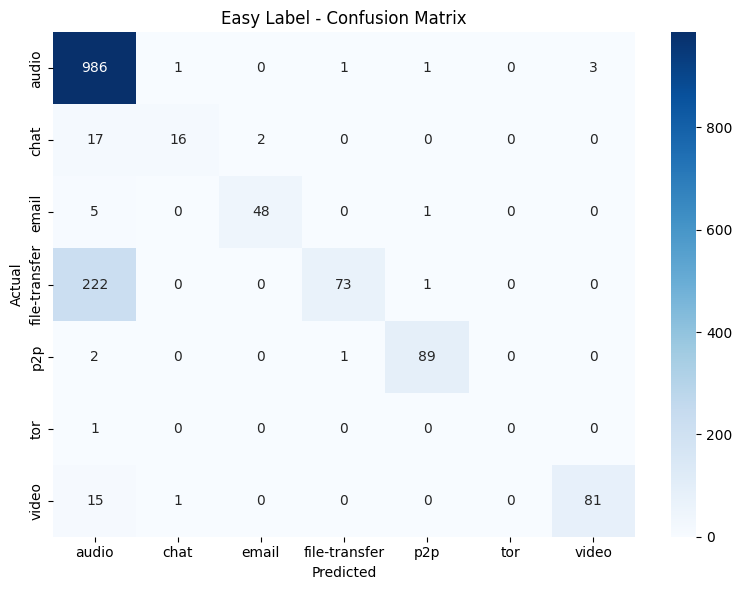

In [21]:
# Step 1: Easy Label Classification

y_easy = final_df["easy_label"]

# Encode labels
le_easy = LabelEncoder()
y_easy_encoded = le_easy.fit_transform(y_easy)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_easy_encoded, test_size=0.2, random_state=42, stratify=y_easy_encoded
)

# Train Random Forest
rf_easy = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_easy.fit(X_train, y_train)

# Predictions
y_pred_easy = rf_easy.predict(X_test)
y_proba_easy = rf_easy.predict_proba(X_test)

# Metrics
f1_easy = f1_score(y_test, y_pred_easy, average='weighted')
print(f"Easy Label - F1 Score (weighted): {f1_easy:.4f}")

# mAP (average precision per class, then mean)
map_easy = np.mean([
    average_precision_score((y_test == i).astype(int), y_proba_easy[:, i])
    for i in range(len(le_easy.classes_))
])
print(f"Easy Label - mAP: {map_easy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_easy, target_names=le_easy.classes_))

# Confusion matrix
cm_easy = confusion_matrix(y_test, y_pred_easy)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_easy, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_easy.classes_, yticklabels=le_easy.classes_)
plt.title('Easy Label - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Medium Label (18 classes)


Medium Label - F1 Score (weighted): 0.6764
Medium Label - mAP: 0.8703

Classification Report:
              precision    recall  f1-score   support

         aim       1.00      0.67      0.80         3
       email       1.00      0.85      0.92        54
    facebook       0.95      0.30      0.46       348
        ftps       0.96      0.92      0.94        48
       gmail       0.00      0.00      0.00         4
    hangouts       0.77      0.62      0.69       445
         icq       0.00      0.00      0.00         2
     netflix       1.00      0.50      0.67         2
        sftp       1.00      0.95      0.98        22
       skype       0.54      0.92      0.68       487
     spotify       1.00      1.00      1.00        15
     torrent       0.96      0.99      0.97        92
       vimeo       1.00      1.00      1.00        20
  voipbuster       0.88      0.64      0.74        22
     youtube       1.00      0.33      0.50         3

    accuracy                           0

/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

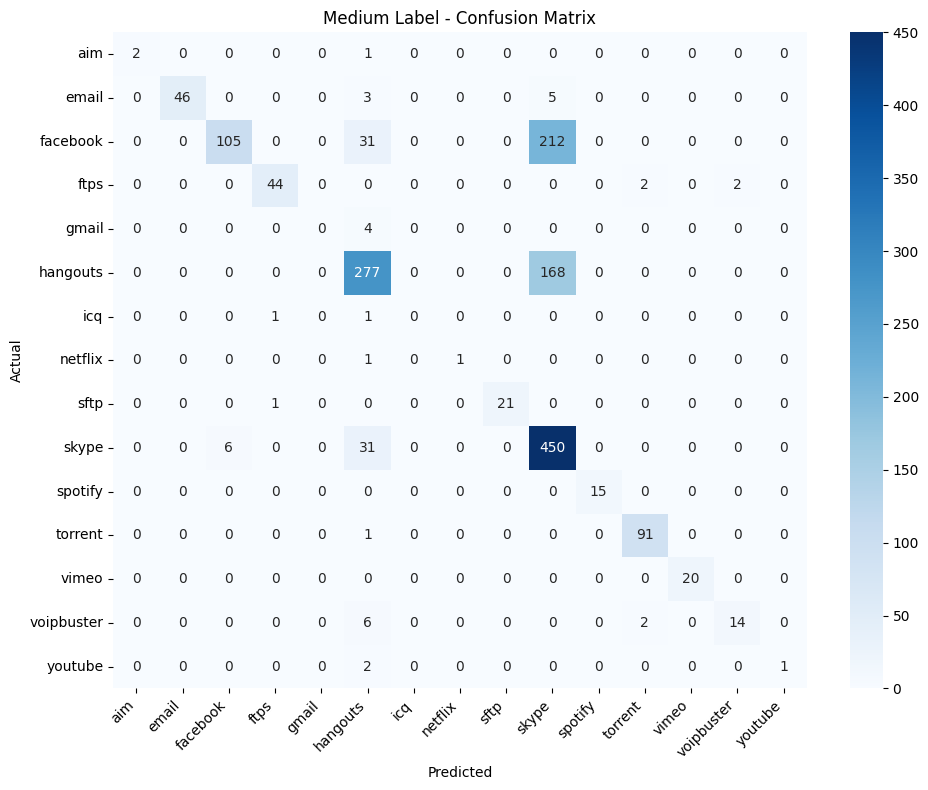

In [22]:
# Step 2: Medium Label Classification

y_medium = final_df["medium_label"]

# Encode labels
le_medium = LabelEncoder()
y_medium_encoded = le_medium.fit_transform(y_medium)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_medium_encoded, test_size=0.2, random_state=42, stratify=y_medium_encoded
)

# Train Random Forest
rf_medium = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_medium.fit(X_train, y_train)

# Predictions
y_pred_medium = rf_medium.predict(X_test)
y_proba_medium = rf_medium.predict_proba(X_test)

# Metrics
f1_medium = f1_score(y_test, y_pred_medium, average='weighted')
print(f"Medium Label - F1 Score (weighted): {f1_medium:.4f}")

# mAP
map_medium = np.mean([
    average_precision_score((y_test == i).astype(int), y_proba_medium[:, i])
    for i in range(len(le_medium.classes_))
])
print(f"Medium Label - mAP: {map_medium:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_medium, target_names=le_medium.classes_))

# Confusion matrix
cm_medium = confusion_matrix(y_test, y_pred_medium)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_medium, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_medium.classes_, yticklabels=le_medium.classes_)
plt.title('Medium Label - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Hard Label (31 classes)


Hard Label - F1 Score (weighted): 0.6678
Hard Label - mAP: 0.8622

Classification Report:
                precision    recall  f1-score   support

      aim-chat       1.00      0.33      0.50         3
         email       0.94      0.85      0.89        54
facebook-audio       0.54      0.84      0.65       334
 facebook-chat       0.00      0.00      0.00         3
facebook-video       1.00      0.45      0.62        11
     ftps-down       1.00      0.60      0.75         5
       ftps-up       0.98      1.00      0.99        43
    gmail-chat       0.00      0.00      0.00         4
hangouts-audio       0.62      0.83      0.71       411
 hangouts-chat       0.00      0.00      0.00         2
hangouts-video       0.92      0.72      0.81        32
      icq-chat       0.00      0.00      0.00         2
       netflix       1.00      0.50      0.67         2
       sftp-up       1.00      0.91      0.95        22
   skype-audio       0.99      0.48      0.65       210
    skype-cha

/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

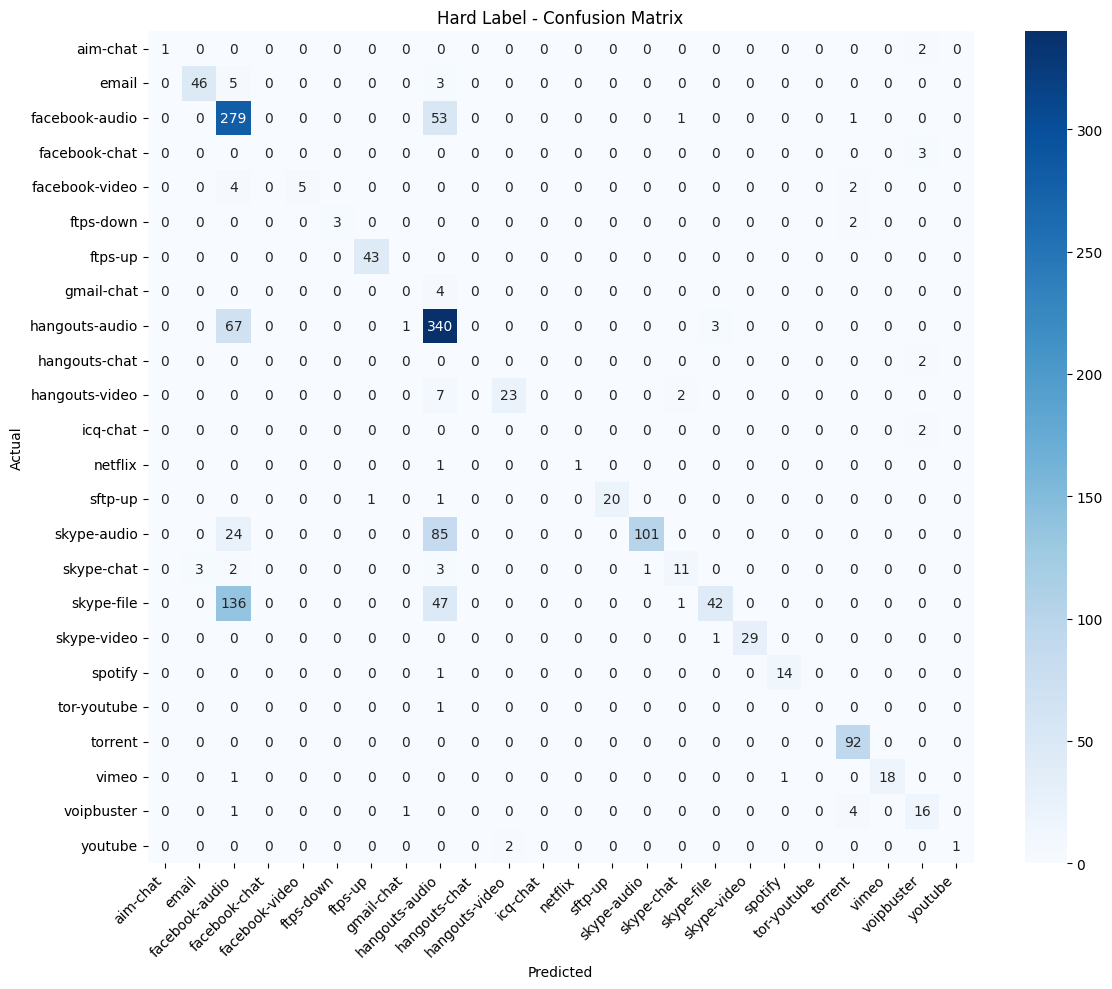

In [23]:
# Step 3: Hard Label Classification

y_hard = final_df["hard_label"]

# Encode labels
le_hard = LabelEncoder()
y_hard_encoded = le_hard.fit_transform(y_hard)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_hard_encoded, test_size=0.2, random_state=42, stratify=y_hard_encoded
)

# Train Random Forest
rf_hard = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_hard.fit(X_train, y_train)

# Predictions
y_pred_hard = rf_hard.predict(X_test)
y_proba_hard = rf_hard.predict_proba(X_test)

# Metrics
f1_hard = f1_score(y_test, y_pred_hard, average='weighted')
print(f"Hard Label - F1 Score (weighted): {f1_hard:.4f}")

# mAP
map_hard = np.mean([
    average_precision_score((y_test == i).astype(int), y_proba_hard[:, i])
    for i in range(len(le_hard.classes_))
])
print(f"Hard Label - mAP: {map_hard:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_hard, target_names=le_hard.classes_))

# Confusion matrix
cm_hard = confusion_matrix(y_test, y_pred_hard)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_hard, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_hard.classes_, yticklabels=le_hard.classes_)
plt.title('Hard Label - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## SVM with nPrint


In [24]:
def train_eval_svm_for_label_nprint(df, feature_cols, label_col, test_size=0.2, random_state=0):
    """
    SVM experiment with an 80 / 20 train test split for nPrint

    - 80 percent train, 20 percent test (stratified by label)
    - Standardization + RBF SVM (C = 1.0, gamma = 'scale')
    - Reports F1 (macro, weighted, micro) and mAP (macro) on the test set
    """

    # 1. Build X, y
    X = df[feature_cols].values
    y = df[label_col].values

    # 2. 80 / 20 stratified train / test split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        stratify=y,
        random_state=random_state,
    )

    print(f"[{label_col}] train size: {len(X_train)}, test size: {len(X_test)}")

    # 3. SVM pipeline  standardization + RBF SVM
    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(
            kernel="rbf",
            C=1.0,
            gamma="scale",
            probability=True,  # needed for mAP
        )),
    ])

    # 4. Train on full training set
    svm_clf.fit(X_train, y_train)

    # 5. Predictions on test set
    y_pred = svm_clf.predict(X_test)

    # 6. F1 scores
    f1_macro    = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")
    f1_micro    = f1_score(y_test, y_pred, average="micro")

    # 7. mAP (macro, one versus rest)
    classes = np.unique(y_train)  # classes seen in training
    y_true_bin = label_binarize(y_test, classes=classes)
    y_scores   = svm_clf.predict_proba(X_test)   # n_samples x n_classes
    mAP_macro  = average_precision_score(y_true_bin, y_scores, average="macro")

    print(f"\n[{label_col}] test F1 (macro):      {f1_macro:.4f}")
    print(f"[{label_col}] test F1 (weighted):   {f1_weighted:.4f}")
    print(f"[{label_col}] test F1 (micro):      {f1_micro:.4f}")
    print(f"[{label_col}] test mAP (macro):     {mAP_macro:.4f}")

    print("\nClassification report (test):")
    print(classification_report(y_test, y_pred))

    cm_test = confusion_matrix(y_test, y_pred)

    return {
        "model": svm_clf,
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "f1_micro": f1_micro,
        "mAP_macro": mAP_macro,
        "cm_test": cm_test,
    }

### Easy Label (7 classes)


In [25]:
nprint_df = final_df.drop(columns=["flow_id", "src_ip"])
nprint_df.dropna(inplace=True)
feature_cols = [
    c for c in nprint_df.columns if c not in label_cols
]

nprint_res_easy = train_eval_svm_for_label_nprint(nprint_df, feature_cols, "easy_label")


[easy_label] train size: 6265, test size: 1567

[easy_label] test F1 (macro):      0.6395
[easy_label] test F1 (weighted):   0.8010
[easy_label] test F1 (micro):      0.8296
[easy_label] test mAP (macro):     0.7472

Classification report (test):
               precision    recall  f1-score   support

        audio       0.80      0.99      0.88       992
         chat       0.91      0.29      0.43        35
        email       0.98      0.81      0.89        54
file-transfer       1.00      0.33      0.50       296
          p2p       0.94      0.98      0.96        92
          tor       0.00      0.00      0.00         1
        video       0.90      0.74      0.81        97

     accuracy                           0.83      1567
    macro avg       0.79      0.59      0.64      1567
 weighted avg       0.86      0.83      0.80      1567



/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

### Medium Label (18 classes)


In [26]:
nprint_res_medium = train_eval_svm_for_label_nprint(nprint_df, feature_cols, "medium_label")


[medium_label] train size: 6265, test size: 1567

[medium_label] test F1 (macro):      0.5921
[medium_label] test F1 (weighted):   0.6527
[medium_label] test F1 (micro):      0.6541
[medium_label] test mAP (macro):     0.8709

Classification report (test):
              precision    recall  f1-score   support

         aim       0.00      0.00      0.00         3
       email       0.96      0.89      0.92        54
    facebook       0.55      0.53      0.54       348
        ftps       0.98      0.83      0.90        48
       gmail       1.00      0.25      0.40         4
    hangouts       0.65      0.62      0.64       445
         icq       0.00      0.00      0.00         2
     netflix       0.00      0.00      0.00         2
        sftp       1.00      0.95      0.98        22
       skype       0.59      0.66      0.62       487
     spotify       1.00      0.93      0.97        15
     torrent       0.92      0.98      0.95        92
       vimeo       0.84      0.80      0

/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

### Hard Label (31 classes)


In [27]:
nprint_res_hard = train_eval_svm_for_label_nprint(nprint_df, feature_cols, "hard_label")


[hard_label] train size: 6265, test size: 1567

[hard_label] test F1 (macro):      0.5370
[hard_label] test F1 (weighted):   0.5940
[hard_label] test F1 (micro):      0.6324
[hard_label] test mAP (macro):     0.7838

Classification report (test):
                precision    recall  f1-score   support

      aim-chat       1.00      0.33      0.50         3
         email       0.91      0.89      0.90        54
facebook-audio       0.49      0.73      0.59       333
 facebook-chat       0.00      0.00      0.00         3
facebook-video       1.00      0.18      0.31        11
     ftps-down       1.00      0.20      0.33         5
       ftps-up       1.00      1.00      1.00        43
    gmail-chat       0.67      1.00      0.80         4
hangouts-audio       0.55      0.82      0.65       411
 hangouts-chat       0.00      0.00      0.00         2
hangouts-video       0.96      0.81      0.88        32
      icq-chat       0.00      0.00      0.00         2
       netflix       0.0

/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

## MLP with nPrint


### Easy Label (7 classes)


nPrint features count: 1776
nPrint samples count: 7832

MLP Classification for: easy_label
Number of samples: 7832
Number of features: 1776
Number of classes: 7
Classes: ['audio' 'chat' 'email' 'file-transfer' 'p2p' 'tor' 'video']
Train size: 6265
Test size: 1567

Training MLP...
Training completed in 102 iterations

--- Results for easy_label ---
Test F1 (macro):    0.7831
Test F1 (weighted): 0.9103
Test F1 (micro):    0.9100
Test mAP (macro):   0.8257

Classification Report:
               precision    recall  f1-score   support

        audio       0.94      0.93      0.93       992
         chat       0.89      0.94      0.92        35
        email       0.98      0.87      0.92        54
file-transfer       0.79      0.83      0.81       296
          p2p       0.97      0.98      0.97        92
          tor       0.00      0.00      0.00         1
        video       0.92      0.94      0.93        97

     accuracy                           0.91      1567
    macro avg       0

/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

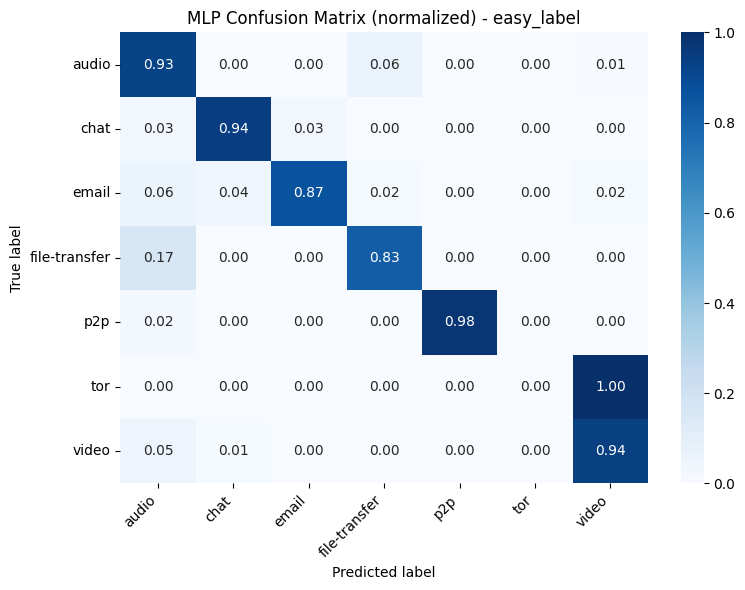

In [28]:
# MLP on nPrint features - Easy Label

# Check if nprint_df exists and has the required data
label_cols = ["easy_label", "medium_label", "hard_label"]

if 'nprint_df' not in dir() or nprint_df is None:
    print("Warning: nprint_df not found. Skipping nPrint MLP experiments.")
    print("Make sure to run the nPrint data loading cells first.")
    mlp_nprint_easy = None
else:
    # Prepare nPrint feature columns
    nprint_feature_cols = [c for c in nprint_df.columns if c not in label_cols]
    
    print(f"nPrint features count: {len(nprint_feature_cols)}")
    print(f"nPrint samples count: {len(nprint_df)}")
    
    # Run MLP for easy label on nPrint data
    mlp_nprint_easy = train_eval_mlp_for_label(
        df=nprint_df,
        feature_cols=nprint_feature_cols,
        label_col="easy_label",
        random_state=RANDOM_SEED,
    )


### Medium Label (18 classes)



MLP Classification for: medium_label
Number of samples: 7832
Number of features: 1776
Number of classes: 15
Classes: ['aim' 'email' 'facebook' 'ftps' 'gmail' 'hangouts' 'icq' 'netflix' 'sftp'
 'skype' 'spotify' 'torrent' 'vimeo' 'voipbuster' 'youtube']
Train size: 6265
Test size: 1567

Training MLP...
Training completed in 166 iterations

--- Results for medium_label ---
Test F1 (macro):    0.8359
Test F1 (weighted): 0.8699
Test F1 (micro):    0.8705
Test mAP (macro):   0.8933

Classification Report:
              precision    recall  f1-score   support

         aim       1.00      0.33      0.50         3
       email       0.98      0.89      0.93        54
    facebook       0.88      0.83      0.85       348
        ftps       0.94      0.92      0.93        48
       gmail       0.75      0.75      0.75         4
    hangouts       0.84      0.90      0.87       445
         icq       1.00      0.50      0.67         2
     netflix       1.00      0.50      0.67         2
      

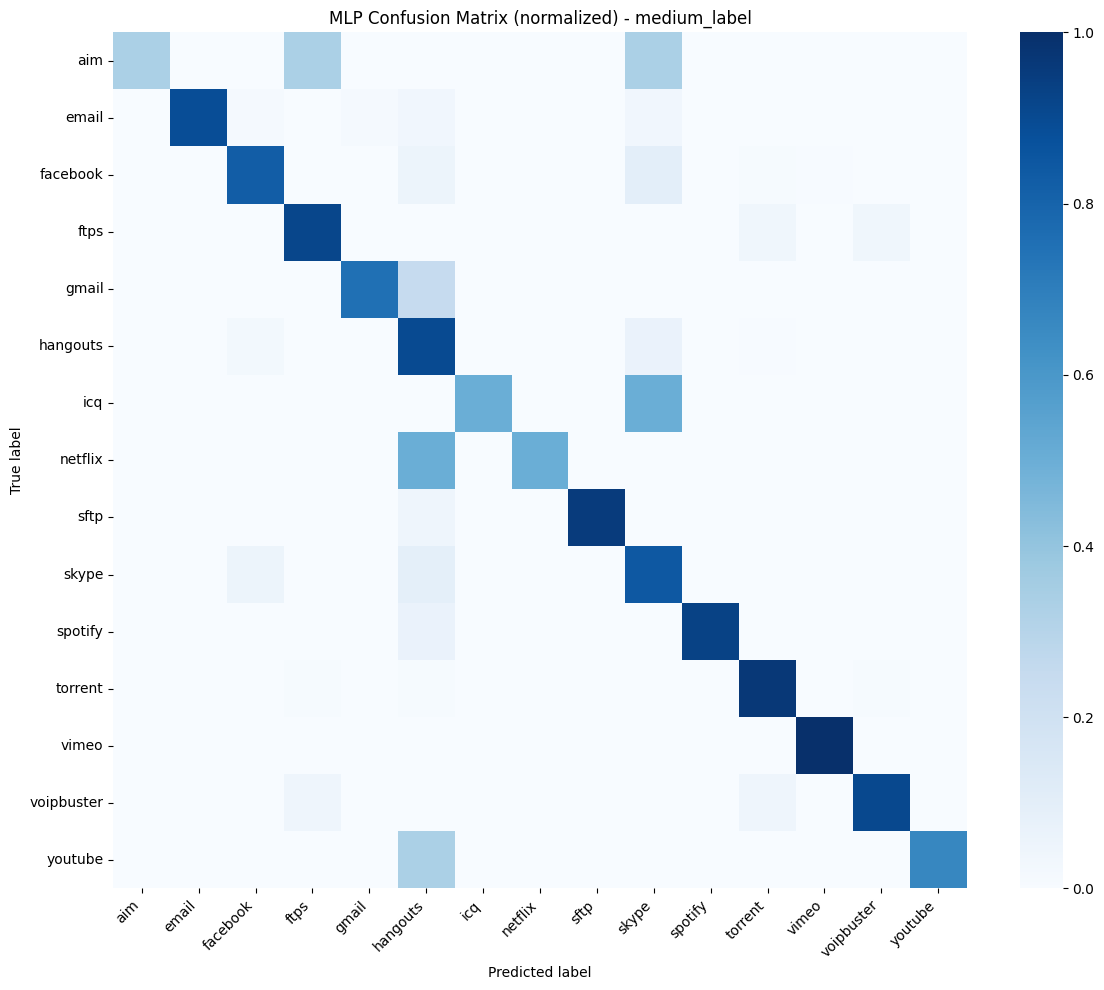

In [29]:
# MLP on nPrint features - Medium Label

if 'nprint_df' in dir() and nprint_df is not None:
    mlp_nprint_medium = train_eval_mlp_for_label(
        df=nprint_df,
        feature_cols=nprint_feature_cols,
        label_col="medium_label",
        random_state=RANDOM_SEED,
    )
else:
    mlp_nprint_medium = None


### Hard Label (31 classes)



MLP Classification for: hard_label
Number of samples: 7832
Number of features: 1776
Number of classes: 24
Classes: ['aim-chat' 'email' 'facebook-audio' 'facebook-chat' 'facebook-video'
 'ftps-down' 'ftps-up' 'gmail-chat' 'hangouts-audio' 'hangouts-chat'
 'hangouts-video' 'icq-chat' 'netflix' 'sftp-up' 'skype-audio'
 'skype-chat' 'skype-file' 'skype-video' 'spotify' 'tor-youtube' 'torrent'
 'vimeo' 'voipbuster' 'youtube']
Train size: 6265
Test size: 1567

Training MLP...
Training completed in 143 iterations

--- Results for hard_label ---
Test F1 (macro):    0.8129
Test F1 (weighted): 0.8634
Test F1 (micro):    0.8641
Test mAP (macro):   0.8539

Classification Report:
                precision    recall  f1-score   support

      aim-chat       1.00      1.00      1.00         3
         email       0.90      0.87      0.89        54
facebook-audio       0.85      0.85      0.85       333
 facebook-chat       1.00      0.67      0.80         3
facebook-video       0.73      0.73      0

/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/faizhilaly/Documents/ml_systems_final/final_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

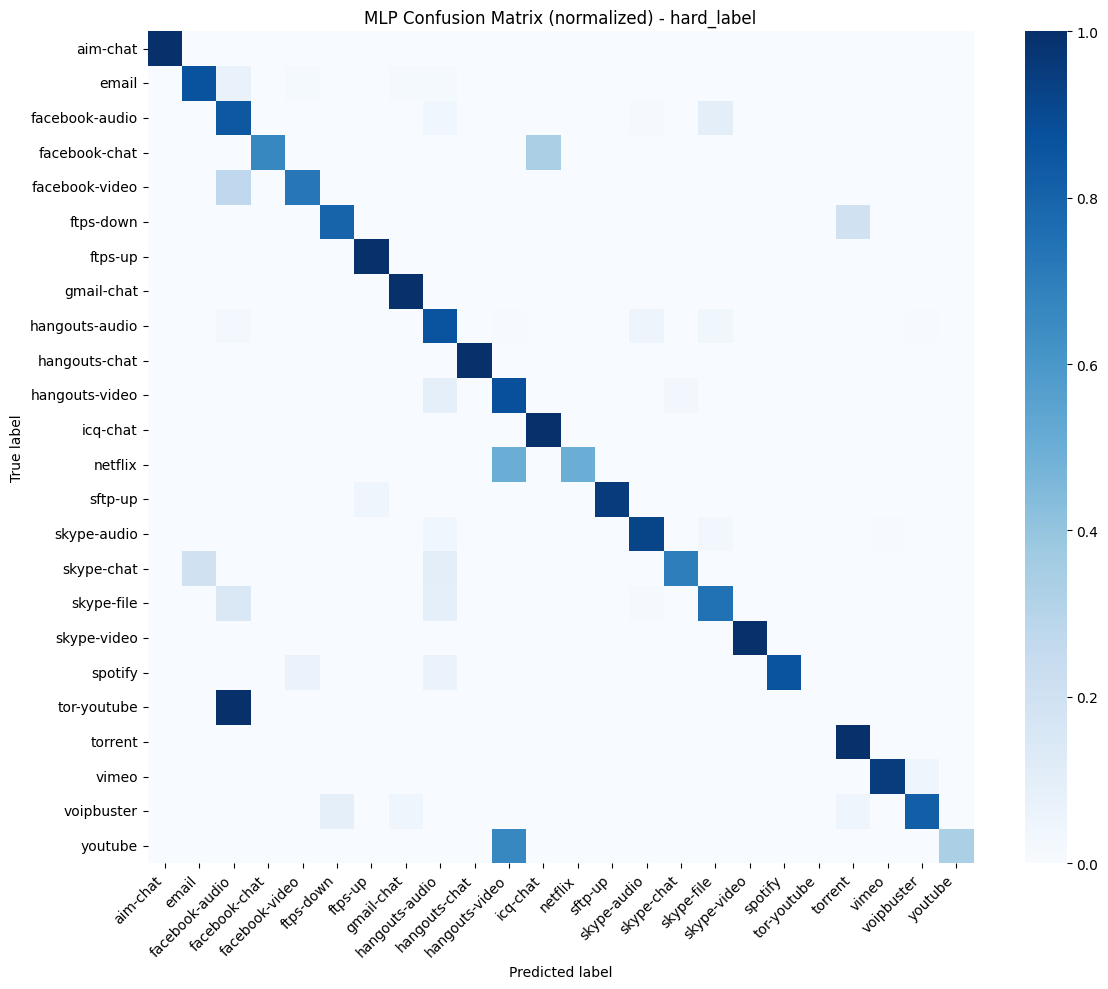

In [30]:
# MLP on nPrint features - Hard Label

if 'nprint_df' in dir() and nprint_df is not None:
    mlp_nprint_hard = train_eval_mlp_for_label(
        df=nprint_df,
        feature_cols=nprint_feature_cols,
        label_col="hard_label",
        random_state=RANDOM_SEED,
    )
else:
    mlp_nprint_hard = None
